In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
import seaborn as sns
from hocelot.dlutils import get_col_feats,open
from datetime import datetime
sns.set_style("whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 400)
pd.set_option('max_colwidth',400)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from hocelot.dlmetadata.hocelot_types import HOCELOT_DTYPES, HOCELOT_FTYPES
from hocelot.dlmetadata.log_transformable_features import LOG_TRANSFORMABLE_1, LOG_TRANSFORMABLE_2
from hocelot.rdt.models import RDTransformer
import joblib
import bisect
import os
import pickle
import joblib
import re
import string
import subprocess
import random
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import lightgbm
from xgboost import XGBClassifier
from multiprocessing import cpu_count
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score, roc_curve
from hocelot.dlutils import get_col_feats, read_raw_data
from hocelot.dlutils import open as open_dlutils # open for saving PKL
#from hocelot.dlutils.miscellaneous import RANDOM_SEED, hocelot_colors
from hocelot.rdt import RDTransformer
from hocelot.dlmodels import XGBClassifierSelector
from hocelot.dlplots import ModelResultsGrapher, ModelExplainabilityGrapher, DefaultGrapher
#from hocelot.dlplots.classification.general_plots import plot_target_stability
from hocelot.dlmetadata import HOCELOT_DTYPES, HOCELOT_FTYPES, LOG_TRANSFORMABLE_1
from hocelot.dlutils.raw_data_reader import read_raw_data
from hocelot.dlutils import open
plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 100)
HOCELOT_YELLOW = '#FDD226'
HOCELOT_BLACK = '#000000'
HOCELOT_RED = '#FF5753'
HOCELOT_BLUE = '#2B3252'
HOCELOT_WHITE = '#FFFFFF'
%matplotlib inline
warnings.filterwarnings('ignore')

# CARGAR FICHEROS

In [3]:
data_pagos = pd.read_excel('gs://zrs/televia/Cartera vencida prepago_Autopistas Urbanas_042023_.xlsx')
print(data_pagos.shape)
data_pagos = data_pagos.loc[2:]

(12130, 24)


#### Limpio el dataset

In [4]:
nuevo_encabezado = data_pagos.iloc[0]
data_pagos.columns = nuevo_encabezado
data_pagos = data_pagos[1:]

In [5]:
data_pagos.tail()

2,NaN,ID_CUSTOMER,ID_ACCOUNT,ID_TAG,DT_MOV_DATE_TS,TIPO_VIAJE,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,ID_ACCOUNT_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR
12125,NaN,687088,0000697702,09900737284,2023-03-01 01:15:21,Cargo por peaje,2023-02-28 10:05:06,596122558,López Portillo P.,Periférico,VB,106.2400,-73.2800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,No recuperado,57
12126,NaN,2436666,0002478875,OHLM01138405,2023-03-01 00:47:02,Cargo por peaje,2023-02-28 18:05:18,596122365,Entr. Portico Oriente,Lago de Guadalupe,VB,87.4500,-39.2300,OHLM01138405,2478875,2023-03-06 10:58:29,Recargas App TeleVía,596883212,300,260.7700,6,1,Recuperado,0
12127,NaN,2917952,0002921877,OHLM01498579,2023-03-01 00:33:09,Cargo por peaje,2023-02-28 15:03:12,596121828,Entr. Portico Oriente,Gustavo Baz Prada,VB,21.4400,-1.1100,OHLM01498579,2921877,2023-03-15 15:23:02,Recargas OXXO,598177535,500,498.8900,15,1,Recuperado,0
12128,NaN,2539511,0002578203,OHLM01189964,2023-03-01 00:25:27,Cargo por peaje,2023-02-28 09:40:01,596121652,Entr. Portico Poniente,Reforma Centro,Aunorte,37.6900,-4.6200,OHLM01189964,2578203,2023-03-01 06:29:00,Recarga sms Movivendor,596138514,490,485.3800,1,1,Recuperado,0
12129,NaN,2761009,0002775405,OHLM01346420,2023-03-01 00:23:28,Cargo por peaje,2023-02-28 15:28:26,596121403,Entr. Portico Oriente,Tepalcapa,VB,122.3100,-18.6300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,No recuperado,57


In [6]:
data = pd.read_excel('gs://zrs/televia/televia_RFI Datos Personales_Televia_23052023.xlsx')
print(data.shape)
data.head()

(60241, 19)


,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Tipo vía,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Estado civil,Fecha alta contrato,Fecha baja
0,869,896,JOSE CARLOS,HERRERA,MOLINA,10/05/69,HEMC690510FM0,CEIBA 163 MANZANA 34 LOTE 34B CUAUTITLAN IZCALLI 54715,CALLE,CEIBA 163 MANZANA 34 LOTE,34B,FRACCIONAMIENTO EXHACIENDA SAN MIGUEL II,CUAUTITLAN IZCALLI,México,carlos@ikevo.com,5591983661,NaN,2009-10-07 00:00:00.0000000,NaN
1,10271,10608,SERGIO,CARRANZA,VELAZQUEZ,18/01/63,CAVS630118AV0,CIENEGA 65 ATIZAPAN 52987,CALLE,CIENEGA,65,LOMAS DE CAPISTRANO,ATIZAPAN,México,secave2013@yahoo.com.mx,58142932,NaN,2009-10-15 00:00:00.0000000,NaN
2,10856,11207,GUSTAVO ANTONIO,RIZO,LOPEZ,08/05/60,RILG600508HI3,CUAHUTEMOC 21 Tlalnepantla de Baz México 54030,CALLE,CUAHUTEMOC,21,SAN JAVIER,Tlalnepantla de Baz,México,gustavorizolopez@gmail.com,5555608958,NaN,2009-10-16 00:00:00.0000000,NaN
3,11689,12061,MARISSA GABRIELA,GAMA,NaN,29/07/62,GAGM620729RH1,PLAZA FIESTA IZCALLI LOCAL I-2 EdoMex México 54740,CALLE,PLAZA FIESTA IZCALLI LOCAL,I-2,Naucalpan,EdoMex,México,gabbygama@hotmail.com,5553482067,NaN,2009-10-16 00:00:00.0000000,NaN
4,25891,26957,EDITH DEYADIRA,LOPEZ,CRUZ,10/08/76,LOCE7608104F5,AHORRO POPULAR 1 ATIZAPAN DE ZARAGOZA 52966,CALLE,AHORRO POPULAR,1,MEXICO NUEVO,ATIZAPAN DE ZARAGOZA,México,facturacionloce@gmail.com,59505067,NaN,2010-01-05 00:00:00.0000000,NaN


#### corrijo formato de las variables id para que crucen perfectamente

In [7]:
data_pagos['ID_CUSTOMER'] = data_pagos['ID_CUSTOMER'].astype(str).str.rjust(10,'0')
data_pagos['ID_ACCOUNT'] = data_pagos['ID_ACCOUNT'].astype(str).str.rjust(10,'0')

In [8]:
data['ID_CUSTOMER'] = data['ID_CUSTOMER'].astype(str).str.rjust(10,'0')
data['ID_ACCOUNT'] = data['ID_ACCOUNT'].astype(str).str.rjust(10,'0')

#### cruzo ambos datasets

In [16]:
data_2 = data.merge(data_pagos, how='inner', on=['ID_CUSTOMER','ID_ACCOUNT'])

#### limpio dataset

In [17]:
data_2 = data_2.iloc[:, :19].join(data_2.iloc[:, 20:])

In [21]:
print(data_2.shape)
data_2.head()

(905, 36)


,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,ID_ACCOUNT_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR
0,0000055845,0000061687,LUIS ENRIQUE,ROURA,Y CASTILLA,21/03/46,ROCL460321C40,CALLE 15 3 MIGUEL HIDALGO CDMX 11650,CALLE 15,3,Reforma Social,MIGUEL HIDALGO,CDMX,luisroura@hotmail.com,5555200381,2010-09-15 00:00:00.0000000,OHLM01008745,2023-03-23 06:21:08,2023-03-16 14:00:58,599282902,Lomas Verdes,Ent. Portico Poniente,VB,27.4200,-145.8400,OHLM01008745,61687,2023-03-23 16:13:25,Recargas App TeleVía,599396494,500,354.1600,7,1,Recuperado,0
1,0000675166,0000685553,OSCAR,SANCHEZ,NaN,05/02/74,SAMO740205TV6,SINALOA 105 EdoMex México 54050,SINALOA,105,Jacarandas,EdoMex,México,oscarsan@hotmail.com,5560090725,2013-08-05 12:22:45.0000000,09900728265,2023-03-30 11:11:52,2023-03-30 09:39:29,600385341,San Antonio,Entr. Portico Oriente,Aunorte,93.4800,-36.9000,9900728265,685553,2023-03-30 15:33:58,Recargas App TeleVía,600426150,200,163.1000,0,1,Recuperado,0
2,0000694025,0000704650,ISRAEL,DIAZ,VÁZQUEZ,25/09/81,DIVI810925VC9,OCEANO ÁRTICO 83 B ATIZAPÁN DE ZARAGOZA México 52947,OCEANO ÁRTICO 83,B,LOMAS LINDAS,ATIZAPÁN DE ZARAGOZA,México,israidea@yahoo.com.mx,5548358590,2013-08-29 12:49:48.0000000,09900722917,2023-04-13 02:47:48,2023-04-12 20:38:48,602326604,Parque Marte,Entr. Portico Oriente,Aunorte,39.4700,-1.0700,9900722917,704650,2023-04-26 08:13:31,7 eleven,604265343,488,486.9300,13,1,Recuperado,0
3,0001972223,0002022915,CARMEN MARGARITA,RODRIGUEZ,MEDRANO,06/11/72,ROMC721106CE4,Lago GUIJA NUM 72 DEPT 704 72 MIGUEL HIDALGO CDMX 11410,Lago GUIJA NUM 72 DEPT 704,72,Tacuba,MIGUEL HIDALGO,CDMX,carmenarjo@hotmail.com,5554354038,2019-02-13 11:06:58.0000000,OHLM00569564,2023-04-06 03:53:00,2023-04-05 11:02:28,601438770,Gustavo Baz Poniente,Ent. Portico Poniente,VB,19.6100,-123.2500,OHLM00569564,2022915,2023-04-10 08:46:27,Recargas App TeleVía,601893121,500,376.7500,5,1,Recuperado,0
4,0002041879,0002090461,Kena,Mañon,Garcia,12/34/12,AAAA123412A11,A Plaza 11-101 EdoMex CDMX 53390,A Plaza,11-101,Naucalpan,EdoMex,CDMX,kenamg945@gmail.com,5611097787,2019-04-29 21:05:36.0000000,OHLM00490015,2023-04-22 07:54:44,2023-04-21 16:41:38,603741464,Entr. Portico Poniente,Salida San Antonio Poniente,Aunorte,99.9600,-66.4800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,No recuperado,5


#### para entender los montos del dataset

In [30]:
print(data_2[data_2['SALDO_NEGATIVO']+data_2['MONTO_RECARGA']!=data_2['SALDO_RECARGA']].shape)
data_2[data_2['SALDO_NEGATIVO']+data_2['MONTO_RECARGA']-data_2['SALDO_RECARGA']>.01].head()

(196, 36)


,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,ID_ACCOUNT_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR
10,0003220767,0003230658,Glenda Iliana,Meda,Loera,06/05/78,MELG780506253,San Marcos 33 Nicolas Romero Estado de México México 53390,San Marcos,33,Paseo San Carlos,Nicolas Romero Estado de México,México,glenmedaloera@gmail.com,5625011904,2022-12-06 23:01:53.0000000,OHLM01870504,2023-03-04 08:33:51,2023-03-04 07:52:53,596623808,Dep. Israelita Poniente,Constituyentes Poniente,Aunorte,54.3500,-87.2700,OHLM01870504,3230658,2023-03-10 16:51:58,Recargas App TeleVía,597553571,400,177.7300,6,1,Recuperado,0
63,0002311326,0002354028,ISRAEL ADAN,LUNA,OSORIO,05/10/77,LUOI771005JUA,CALZADA VALLEJO 1268 EdoMex CDMX 7620,CALZADA VALLEJO,1268,Naucalpan,EdoMex,CDMX,israel.luna.o@hotmail.com,5545788164,2019-12-17 20:02:41.0000000,OHLM00971882,2023-03-24 15:52:40,2023-03-23 20:21:52,599583144,San Antonio,Entr. Portico Oriente,Aunorte,93.4800,-23.5500,OHLM00971882,2354028,2023-03-25 12:20:47,7 eleven,599705427,988,925.0900,2,1,Recuperado,0
64,0002446979,0002489037,JORGE,MENDOZA,BONALES,15/11/93,MEBJ931115AY4,CONFIDENCIAL 0 CONFIDENCIAL 0,CONFIDENCIAL,0,CONFIDENCIAL,CONFIDENCIAL,CDMX,bonalesjorge@gmail.com,0000000000,2020-08-07 21:01:56.0000000,OHLM01097770,2023-04-08 13:37:31,2023-04-08 11:24:54,601693056,Entr. Portico Oriente,Valle Dorado,VB,71.4600,-11.1300,OHLM01097770,2489037,2023-04-09 06:48:26,Recargas Mercado Pago,601752435,494,445.9800,1,1,Recuperado,0
82,0002207281,0002251098,Arely Vanessa,Chavez,Uribe,12/34/12,AAAA123412A11,0 0 EdoMex CDMX 53390,0,0,Naucalpan,EdoMex,CDMX,vanessachavezk@gmail.com,5552143501,2019-09-23 13:00:21.0000000,OHLM00860463,2023-03-23 22:14:59,2023-03-16 20:53:07,599467753,Constituyentes Poniente,Entr. Portico Oriente,Aunorte,61.7600,-93.0500,OHLM00860463,2251098,2023-03-25 12:34:19,Recargas App TeleVía,599707590,500,242.9500,9,1,Recuperado,0
89,0001248903,0001291722,MARIA EULALIA,NIETO,REYES,09/04/84,NIRE8404091YA,JARDIN DEL PEDREGAL 391 TULTEPEC México 54980,JARDIN DEL PEDREGAL,391,HACIENDA DEL JARDIN 1,TULTEPEC,México,fhvg777@yahoo.com.mx,5513984806,2015-10-29 18:15:00.0000000,OHLM00120348,2023-03-23 20:22:34,2023-03-23 20:04:00,599447802,Entr. Portico Oriente,Tepalcapa,VB,122.3100,-16.3800,OHLM00120348,1291722,2023-03-23 22:15:08,Recarga vía,599467777,200,168.6200,0,1,Recuperado,0


#### Creo la variable nombre completo

In [55]:
data_2['Nombre_Completo'] = np.where(data_2['Apellido 2'].notnull(),data_2['Nombre'] + ' ' + data_2['Apellido 1'] + ' ' + data_2['Apellido 2'],data_2['Nombre'] + ' ' + data_2['Apellido 1'])

In [57]:
data_2.head()

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,ID_ACCOUNT_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo
0,0000055845,0000061687,LUIS ENRIQUE,ROURA,Y CASTILLA,21/03/46,ROCL460321C40,CALLE 15 3 MIGUEL HIDALGO CDMX 11650,CALLE 15,3,Reforma Social,MIGUEL HIDALGO,CDMX,luisroura@hotmail.com,5555200381,2010-09-15 00:00:00.0000000,OHLM01008745,2023-03-23 06:21:08,2023-03-16 14:00:58,599282902,Lomas Verdes,Ent. Portico Poniente,VB,27.4200,-145.8400,OHLM01008745,61687,2023-03-23 16:13:25,Recargas App TeleVía,599396494,500,354.1600,7,1,Recuperado,0,LUIS ENRIQUE ROURA Y CASTILLA
1,0000675166,0000685553,OSCAR,SANCHEZ,NaN,05/02/74,SAMO740205TV6,SINALOA 105 EdoMex México 54050,SINALOA,105,Jacarandas,EdoMex,México,oscarsan@hotmail.com,5560090725,2013-08-05 12:22:45.0000000,09900728265,2023-03-30 11:11:52,2023-03-30 09:39:29,600385341,San Antonio,Entr. Portico Oriente,Aunorte,93.4800,-36.9000,9900728265,685553,2023-03-30 15:33:58,Recargas App TeleVía,600426150,200,163.1000,0,1,Recuperado,0,OSCAR SANCHEZ
2,0000694025,0000704650,ISRAEL,DIAZ,VÁZQUEZ,25/09/81,DIVI810925VC9,OCEANO ÁRTICO 83 B ATIZAPÁN DE ZARAGOZA México 52947,OCEANO ÁRTICO 83,B,LOMAS LINDAS,ATIZAPÁN DE ZARAGOZA,México,israidea@yahoo.com.mx,5548358590,2013-08-29 12:49:48.0000000,09900722917,2023-04-13 02:47:48,2023-04-12 20:38:48,602326604,Parque Marte,Entr. Portico Oriente,Aunorte,39.4700,-1.0700,9900722917,704650,2023-04-26 08:13:31,7 eleven,604265343,488,486.9300,13,1,Recuperado,0,ISRAEL DIAZ VÁZQUEZ
3,0001972223,0002022915,CARMEN MARGARITA,RODRIGUEZ,MEDRANO,06/11/72,ROMC721106CE4,Lago GUIJA NUM 72 DEPT 704 72 MIGUEL HIDALGO CDMX 11410,Lago GUIJA NUM 72 DEPT 704,72,Tacuba,MIGUEL HIDALGO,CDMX,carmenarjo@hotmail.com,5554354038,2019-02-13 11:06:58.0000000,OHLM00569564,2023-04-06 03:53:00,2023-04-05 11:02:28,601438770,Gustavo Baz Poniente,Ent. Portico Poniente,VB,19.6100,-123.2500,OHLM00569564,2022915,2023-04-10 08:46:27,Recargas App TeleVía,601893121,500,376.7500,5,1,Recuperado,0,CARMEN MARGARITA RODRIGUEZ MEDRANO
4,0002041879,0002090461,Kena,Mañon,Garcia,12/34/12,AAAA123412A11,A Plaza 11-101 EdoMex CDMX 53390,A Plaza,11-101,Naucalpan,EdoMex,CDMX,kenamg945@gmail.com,5611097787,2019-04-29 21:05:36.0000000,OHLM00490015,2023-04-22 07:54:44,2023-04-21 16:41:38,603741464,Entr. Portico Poniente,Salida San Antonio Poniente,Aunorte,99.9600,-66.4800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,No recuperado,5,Kena Mañon Garcia


## Paso 0: Transformación de formatos

In [61]:
data_2.dtypes

ID_CUSTOMER            object
ID_ACCOUNT             object
Nombre                 object
Apellido 1             object
Apellido 2             object
Fecha de nacimiento    object
CURP o RFC             object
Dirección completa     object
Nombre vía             object
Número vía             object
Colonia                object
Ciudad                 object
Entidad federativa     object
Email                  object
Teléfono               object
Fecha alta contrato    object
ID_TAG                 object
DT_MOV_DATE_TS         object
FECHA_VIAJE            object
ID_TRANS_VIAJE         object
ENTRADA                object
SALIDA                 object
OPERADOR               object
MONTO_VIAJE            object
SALDO_NEGATIVO         object
ID_TAG_C               object
ID_ACCOUNT_C           object
FECHA_RECARGA          object
RECARGA                object
ID_TRANS_RECARGA       object
MONTO_RECARGA          object
SALDO_RECARGA          object
DIAS_RECUPERACIÓN      object
NUMERO_EN_

In [86]:
data_2['Fecha_nacimiento'] = data_2['Fecha de nacimiento'].astype(str).str.split('/').apply(lambda x: '19'+x[2]+'-'+x[1]+'-'+x[0])

In [89]:
data_2['Fecha_nacimiento'] = np.where(data_2['Fecha de nacimiento']<'1920', np.nan,data_2['Fecha de nacimiento'] )

# PASO 1: REVISAR CAMPOS

In [103]:
print(data_2.shape)
data_2.head(2)

(905, 37)


,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento
0,0000055845,0000061687,LUIS ENRIQUE,ROURA,Y CASTILLA,21/03/46,ROCL460321C40,CALLE 15 3 MIGUEL HIDALGO CDMX 11650,CALLE 15,3,Reforma Social,MIGUEL HIDALGO,CDMX,luisroura@hotmail.com,5555200381,2010-09-15 00:00:00,OHLM01008745,2023-03-23 06:21:08,2023-03-16 14:00:58,599282902,Lomas Verdes,Ent. Portico Poniente,VB,27.4200,-145.8400,OHLM01008745,2023-03-23 16:13:25,Recargas App TeleVía,599396494,500,354.1600,7,1,Recuperado,0,LUIS ENRIQUE ROURA Y CASTILLA,21/03/46
1,0000675166,0000685553,OSCAR,SANCHEZ,NaN,05/02/74,SAMO740205TV6,SINALOA 105 EdoMex México 54050,SINALOA,105,Jacarandas,EdoMex,México,oscarsan@hotmail.com,5560090725,2013-08-05 12:22:45,09900728265,2023-03-30 11:11:52,2023-03-30 09:39:29,600385341,San Antonio,Entr. Portico Oriente,Aunorte,93.4800,-36.9000,9900728265,2023-03-30 15:33:58,Recargas App TeleVía,600426150,200,163.1000,0,1,Recuperado,0,OSCAR SANCHEZ,NaN


#### Vemos que puede significar DIAS_RECUPERACIÓN

In [102]:
for col in ['Fecha alta contrato','DT_MOV_DATE_TS','FECHA_VIAJE', 'FECHA_RECARGA']:
    data_2[col] = pd.to_datetime(data_2[col], yearfirst=True)
    data_2[col] = data_2[col].apply(lambda x: datetime())

In [123]:
data_2.head()

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2
0,0000055845,0000061687,LUIS ENRIQUE,ROURA,Y CASTILLA,21/03/46,ROCL460321C40,CALLE 15 3 MIGUEL HIDALGO CDMX 11650,CALLE 15,3,Reforma Social,MIGUEL HIDALGO,CDMX,luisroura@hotmail.com,5555200381,2010-09-15 00:00:00,OHLM01008745,2023-03-23 06:21:08,2023-03-16 14:00:58,599282902,Lomas Verdes,Ent. Portico Poniente,VB,27.4200,-145.8400,OHLM01008745,2023-03-23 16:13:25,Recargas App TeleVía,599396494,500,354.1600,7,1,Recuperado,0,LUIS ENRIQUE ROURA Y CASTILLA,21/03/46,7
1,0000675166,0000685553,OSCAR,SANCHEZ,NaN,05/02/74,SAMO740205TV6,SINALOA 105 EdoMex México 54050,SINALOA,105,Jacarandas,EdoMex,México,oscarsan@hotmail.com,5560090725,2013-08-05 12:22:45,09900728265,2023-03-30 11:11:52,2023-03-30 09:39:29,600385341,San Antonio,Entr. Portico Oriente,Aunorte,93.4800,-36.9000,9900728265,2023-03-30 15:33:58,Recargas App TeleVía,600426150,200,163.1000,0,1,Recuperado,0,OSCAR SANCHEZ,NaN,0
2,0000694025,0000704650,ISRAEL,DIAZ,VÁZQUEZ,25/09/81,DIVI810925VC9,OCEANO ÁRTICO 83 B ATIZAPÁN DE ZARAGOZA México 52947,OCEANO ÁRTICO 83,B,LOMAS LINDAS,ATIZAPÁN DE ZARAGOZA,México,israidea@yahoo.com.mx,5548358590,2013-08-29 12:49:48,09900722917,2023-04-13 02:47:48,2023-04-12 20:38:48,602326604,Parque Marte,Entr. Portico Oriente,Aunorte,39.4700,-1.0700,9900722917,2023-04-26 08:13:31,7 eleven,604265343,488,486.9300,13,1,Recuperado,0,ISRAEL DIAZ VÁZQUEZ,25/09/81,13
3,0001972223,0002022915,CARMEN MARGARITA,RODRIGUEZ,MEDRANO,06/11/72,ROMC721106CE4,Lago GUIJA NUM 72 DEPT 704 72 MIGUEL HIDALGO CDMX 11410,Lago GUIJA NUM 72 DEPT 704,72,Tacuba,MIGUEL HIDALGO,CDMX,carmenarjo@hotmail.com,5554354038,2019-02-13 11:06:58,OHLM00569564,2023-04-06 03:53:00,2023-04-05 11:02:28,601438770,Gustavo Baz Poniente,Ent. Portico Poniente,VB,19.6100,-123.2500,OHLM00569564,2023-04-10 08:46:27,Recargas App TeleVía,601893121,500,376.7500,5,1,Recuperado,0,CARMEN MARGARITA RODRIGUEZ MEDRANO,NaN,4
4,0002041879,0002090461,Kena,Mañon,Garcia,12/34/12,AAAA123412A11,A Plaza 11-101 EdoMex CDMX 53390,A Plaza,11-101,Naucalpan,EdoMex,CDMX,kenamg945@gmail.com,5611097787,2019-04-29 21:05:36,OHLM00490015,2023-04-22 07:54:44,2023-04-21 16:41:38,603741464,Entr. Portico Poniente,Salida San Antonio Poniente,Aunorte,99.9600,-66.4800,NaN,NaT,NaN,NaN,NaN,NaN,NaN,1,No recuperado,5,Kena Mañon Garcia,NaN,NaT


In [122]:
data_2['DIAS_RECUPERACION_2'] = (data_2['FECHA_RECARGA']-data_2['FECHA_VIAJE'])
data_2['DIAS_RECUPERACION_2'] = data_2['DIAS_RECUPERACION_2'].astype(str).str.split(' ').apply(lambda x: x[0])

In [129]:
data_2['DIAS_RECUPERACIÓN'] = data_2['DIAS_RECUPERACIÓN'].astype(str)

In [135]:
print(data_2[(data_2['DIAS_RECUPERACION_2'] != data_2['DIAS_RECUPERACIÓN'])&(data_2['DIAS_RECUPERACIÓN']!='nan')].shape)
data_2[(data_2['DIAS_RECUPERACION_2'] != data_2['DIAS_RECUPERACIÓN'])&(data_2['DIAS_RECUPERACIÓN']!='nan')].head(2)

(484, 38)


,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2
3,0001972223,0002022915,CARMEN MARGARITA,RODRIGUEZ,MEDRANO,06/11/72,ROMC721106CE4,Lago GUIJA NUM 72 DEPT 704 72 MIGUEL HIDALGO CDMX 11410,Lago GUIJA NUM 72 DEPT 704,72,Tacuba,MIGUEL HIDALGO,CDMX,carmenarjo@hotmail.com,5554354038,2019-02-13 11:06:58,OHLM00569564,2023-04-06 03:53:00,2023-04-05 11:02:28,601438770,Gustavo Baz Poniente,Ent. Portico Poniente,VB,19.6100,-123.2500,OHLM00569564,2023-04-10 08:46:27,Recargas App TeleVía,601893121,500,376.7500,5,1,Recuperado,0,CARMEN MARGARITA RODRIGUEZ MEDRANO,NaN,4
5,0002261368,0002304629,ERICK,LOPEZ,LOPEZ,14/05/80,LOLE800514EP5,BLVD DE LAS FUENTES INT 1 489 int 1 estado de mexico México 53390,BLVD DE LAS FUENTES INT 1,489 int 1,fuentes del valle,estado de mexico,México,erikc1405@hotmail.com,5518007058,2019-11-11 20:05:03,OHLM00805478,2023-03-30 16:54:45,2023-03-29 10:37:46,600438445,Entr. Portico Poniente,Salida San Antonio Poniente,Aunorte,99.9600,-60.6300,OHLM00805478,2023-03-31 07:34:27,Recargas App TeleVía,600520883,500,439.3700,2,1,Recuperado,0,ERICK LOPEZ LOPEZ,NaN,1


In [136]:
data_2['CARTERA'].value_counts()

Recuperado       816
No recuperado     89
Name: CARTERA, dtype: int64

In [138]:
data_2[(data_2['CARTERA']=='No recuperado')&(data_2['DIAS_RECUPERACIÓN']!='nan')]

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2


In [140]:
data_2[data_2['DIAS_RECUPERACIÓN']=='nan'].shape

(89, 38)

In [142]:
data_2.head(1)

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2
0,0000055845,0000061687,LUIS ENRIQUE,ROURA,Y CASTILLA,21/03/46,ROCL460321C40,CALLE 15 3 MIGUEL HIDALGO CDMX 11650,CALLE 15,3,Reforma Social,MIGUEL HIDALGO,CDMX,luisroura@hotmail.com,5555200381,2010-09-15,OHLM01008745,2023-03-23 06:21:08,2023-03-16 14:00:58,599282902,Lomas Verdes,Ent. Portico Poniente,VB,27.4200,-145.8400,OHLM01008745,2023-03-23 16:13:25,Recargas App TeleVía,599396494,500,354.1600,7,1,Recuperado,0,LUIS ENRIQUE ROURA Y CASTILLA,21/03/46,7


In [154]:
data_2[(data_2['DIAS_SIN_RECUPERAR']>0)].shape

(82, 38)

In [152]:
data_2[(data_2['DIAS_RECUPERACIÓN']=='nan')&(data_2['DIAS_SIN_RECUPERAR']>=0)].shape

(89, 38)

In [155]:
data_2[(data_2['DIAS_RECUPERACIÓN']=='nan')&(data_2['DIAS_SIN_RECUPERAR']==0)]

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2
7,0002940026,0002943362,JOSE ANTONIO,PADILLA,FRAUSTO,30/08/81,PAFA810830AL8,CALZADA DESIERTO DE LOS LEONES 4375 Álvaro Obregón CDMX 01790,CALZADA DESIERTO DE LOS LEONES,4375,Tetelpan,Álvaro Obregón,CDMX,J.antonio.padilla@icloud.com,5568832447,2021-12-17 09:10:38,OHLM01508838,2023-04-26 16:50:28,2023-04-26 11:39:16,604339955,Entr. Portico Poniente,Salida San Antonio Poniente,Aunorte,99.9600,-26.6000,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,0,JOSE ANTONIO PADILLA FRAUSTO,30/08/81,NaT
188,0003215597,0003225480,Jose Alejandro,Mendez,Reyes,26/01/82,MERA8201269Y2,Cerrada de lago chapultepec 43 Miguel Hidalgo CDMX 53390,Cerrada de lago chapultepec,43,5 de Mayo,Miguel Hidalgo,CDMX,alejandromdzrey@gmail.com,5517250691,2022-12-06 13:00:38,OHLM01873090,2023-04-26 14:01:08,2023-04-26 10:22:21,604309604,Gustavo Baz Poniente,Periférico,VB,15.5700,-6.9800,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,0,Jose Alejandro Mendez Reyes,26/01/82,NaT
263,0001719721,0001783149,CYNTHIA RUBI,REBOLLEDO,MENDEZ,22/01/93,REMC9301224I7,Industria y comercio 11 Chilpancingo de los Bravo Guerrero 39020,Industria y comercio,11,Ruffo Figueroa,Chilpancingo de los Bravo,Guerrero,pevenci_22@hotmail.com,7471863338,2018-07-19 19:53:45,OHLM00400805,2023-04-26 18:34:20,2023-04-26 15:57:08,604359130,Circunvalación,Tepalcapa,VB,79.9400,-126.9000,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,0,CYNTHIA RUBI REBOLLEDO MENDEZ,22/01/93,NaT
313,0000137839,0000146094,OMAR,LOPEZ,ARGUETA,14/08/80,LOAO800814K50,LIBERTAD 202 EdoMex México 54720,LIBERTAD,202,Naucalpan,EdoMex,México,omarlopezargueta@gmail.com,5520518745,2011-06-10 00:00:00,OHLM01002198,2023-04-26 18:41:16,2023-04-26 09:55:25,604360287,Tepalcapa,Periférico,VB,120.0900,-29.3700,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,0,OMAR LOPEZ ARGUETA,NaN,NaT
396,0001702175,0001765929,ANA GABRIELA,CERDA,STREMPLER,02/08/85,CESA850802185,ORIHUELA MANZANA 90 LOTE 10 CASA C 0mz90 Huehuetoca México 54696,ORIHUELA MANZANA 90 LOTE 10 CASA C,0mz90,Ciudad Integral citara,Huehuetoca,México,gerenciaizajemaster@gmail.com,5583891262,2018-07-16 13:15:49,OHLM00437600,2023-04-26 14:09:47,2023-04-26 08:38:57,604311439,Entr. Portico Poniente,Salida San Antonio Poniente,Aunorte,99.9600,-120.1300,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,0,ANA GABRIELA CERDA STREMPLER,NaN,NaT
414,0001641880,0001713100,GUSTAVO SERGIO,LOMAN,VILLARREAL,16/12/54,LOVG541216965,San Antonio 188 Benito Juárez CDMX 53390,San Antonio,188,Ciudad de los Deportes,Benito Juárez,CDMX,admin@hometronix.mx,5537313939,2018-04-05 21:56:23,OHLM00288054,2023-04-26 18:08:44,2023-04-26 09:31:34,604353925,Entr. Portico Oriente,Gustavo Baz Prada,VB,21.4400,-228.1900,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,0,GUSTAVO SERGIO LOMAN VILLARREAL,NaN,NaT
515,0003011924,0003013728,ENRIQUE,PADILLA,GOMEZ,21/02/64,PAGE6402213M7,PRIVADA 2DA. DE NARAXAN 105-A2 EdoMex Michoacán de Ocampo 58070,PRIVADA 2DA. DE NARAXAN,105-A2,Felix Irera,EdoMex,Michoacán de Ocampo,e_padilla@hotmail.com,4431015555,2022-03-08 14:40:28,OHLM01675692,2023-04-26 18:40:11,2023-04-26 08:17:38,604360121,Tepalcapa,Ent. Portico Poniente,VB,121.8200,-153.8300,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,0,ENRIQUE PADILLA GOMEZ,21/02/64,NaT


In [156]:
data_2[data_2['FECHA_VIAJE']>'2023-04-27']

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2


#### miramos si hay alguna recarga que no cubra el monto que se debe

In [157]:
data_2[data_2['MONTO_RECARGA']<abs(data_2['SALDO_NEGATIVO'])].shape

(5, 38)

In [158]:
data_2[data_2['MONTO_RECARGA']<abs(data_2['SALDO_NEGATIVO'])]

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2
132,0003056884,0003058946,Francisco Javier,Amaya,Aguirre,03/12/93,AAAF9312032D4,Tekit 63 CD MX México 53390,Tekit,63,Lomas de Padierna,CD MX,México,btomartinezg@hotmail.com,5611115049,2022-04-27 10:40:04,OHLM01723965,2023-03-24 14:23:45,2023-03-23 09:27:35,599568894,San Antonio,Dep. Israelita Oriente,Aunorte,90.0600,-315.4600,OHLM01723965,2023-03-25 18:12:53,Recargas Mercado Pago,599754792,190,64.5400,2,1,Recuperado,0,Francisco Javier Amaya Aguirre,NaN,2
357,0002184324,0002228412,ISAIAS FRANCISCO,MARTINEZ,NaN,12/11/84,MAOI8411129T0,HACIENDA SAN ANDRES MZ 3 LT 51 145 estado de México México 53390,HACIENDA SAN ANDRES MZ 3 LT 51,145,xaltipa,estado de México,México,bmarif@hotmail.com,5535749928,2019-09-03 16:12:14,OHLM00728530,2023-03-23 06:48:41,2023-03-16 17:15:25,599289477,San Joaquín,Tepalcapa,VB,121.1000,-221.6500,OHLM00728530,2023-03-27 06:11:23,Recargas OXXO,599882864,200,178.3500,11,1,Recuperado,0,ISAIAS FRANCISCO MARTINEZ,NaN,10
409,0003152503,0003157250,Jose oscar,Machuca,peralta,27/09/82,MAPO820927C40,Av paseo de la amistad mza 4 lt 1 73 cuautitlan mexico México 53390,Av paseo de la amistad mza 4 lt 1,73,Fracc paseos del bosque,cuautitlan mexico,México,gisela25092017@gmail.com,5543533250,2022-08-16 12:00:16,OHLM01804251,2023-03-23 23:58:54,2023-03-15 08:38:36,599483479,Entr. Portico Poniente,Salida San Antonio Poniente,Aunorte,99.9600,-162.9900,OHLM01804251,2023-03-24 09:18:30,Recargas App TeleVía,599524766,100,37.0100,9,1,Recuperado,0,Jose oscar Machuca peralta,27/09/82,9
442,0001874555,0001926857,ADRIANA,MARTINEZ,RANGEL,21/11/85,MARA851121UF2,ZACAPOAXTLA MZ 36 LT 21 0 GUSTAVO A MADERO 07510,ZACAPOAXTLA MZ 36 LT 21,0,SAN FELIPE DE JESUS,GUSTAVO A MADERO,CDMX,adriangel_1985@hotmail.com,5571990561,2018-12-12 00:10:52,OHLM00551304,2023-03-23 03:09:28,2023-03-13 18:24:43,599254177,Vallejo Periférico,López Portillo P.,VB,27.7800,-95.1400,OHLM00551304,2023-03-23 18:24:53,Recargas GestoPago Bancos,599423638,90,84.8600,10,1,Recuperado,0,ADRIANA MARTINEZ RANGEL,21/11/85,10
761,0002955700,0002957480,Osvaldo,Santos,Neria,12/34/12,AAAA123412A11,0 0 EdoMex CDMX 53390,0,0,Naucalpan,EdoMex,CDMX,osvaldo.santos23@hotmail.com,5527393365,2022-01-11 12:10:11,OHLM01524581,2023-03-23 06:36:12,2023-03-16 20:19:34,599286323,Entr. Portico Oriente,Tepalcapa,VB,122.3100,-213.1200,OHLM01524581,2023-03-24 06:34:58,Recargas OXXO,599499454,200,86.8800,7,1,Recuperado,0,Osvaldo Santos Neria,NaN,7


vemos que hay 5 casos en los que recargan menos de lo que deben y se les queda un saldo positivo

In [65]:
data_2['ID_ACCOUNT_C'] =data_2['ID_ACCOUNT_C'].astype(str).str.rjust(10,'0')

In [75]:
print(data_2[data_2['ID_ACCOUNT_C']!=data_2['ID_ACCOUNT']].shape)
data_2[data_2['ID_ACCOUNT_C']!=data_2['ID_ACCOUNT']]['ID_ACCOUNT_C'].value_counts()

(89, 37)


0000000nan    89
Name: ID_ACCOUNT_C, dtype: int64

In [76]:
data_2.drop(columns=['ID_ACCOUNT_C'], inplace=True)

# Paso 2: Missing values y valores incorrectos

In [19]:
get_col_feats(data_2)

100%|██████████| 40/40 [00:00<00:00, 1449.35it/s]


,dtype,sample,n_missing,perc_missing,n_unique
ID_CUSTOMER,object,0000055845,0,0.000000,798
ID_ACCOUNT,object,0000061687,0,0.000000,798
Nombre,object,LUIS ENRIQUE,0,0.000000,615
Apellido 1,object,ROURA,0,0.000000,495
Apellido 2,object,Y CASTILLA,65,7.182320,493
Fecha de nacimiento,object,21/03/46,0,0.000000,716
CURP o RFC,object,ROCL460321C40,0,0.000000,730
Dirección completa,object,CALLE 15 3 MIGUEL HIDALGO CDMX 11650,0,0.000000,747
Tipo vía,object,CALLE,0,0.000000,1
Nombre vía,object,CALLE 15,0,0.000000,715


In [20]:
data_2.drop(columns=['Tipo vía','Estado civil','Fecha baja','TIPO_VIAJE'], inplace=True)

In [181]:
data_2[data_2['RECARGA'].isnull()]

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2,longitud_RFC_CURP
4,0002041879,0002090461,Kena,Mañon,Garcia,12/34/12,AAAA123412A11,A Plaza 11-101 EdoMex CDMX 53390,A Plaza,11-101,Naucalpan,EdoMex,CDMX,kenamg945@gmail.com,5611097787,2019-04-29 21:05:36,OHLM00490015,2023-04-22 07:54:44,2023-04-21 16:41:38,603741464,Entr. Portico Poniente,Salida San Antonio Poniente,Aunorte,99.9600,-66.4800,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,5,Kena Mañon Garcia,NaN,NaT,13
7,0002940026,0002943362,JOSE ANTONIO,PADILLA,FRAUSTO,30/08/81,PAFA810830AL8,CALZADA DESIERTO DE LOS LEONES 4375 Álvaro Obregón CDMX 01790,CALZADA DESIERTO DE LOS LEONES,4375,Tetelpan,Álvaro Obregón,CDMX,J.antonio.padilla@icloud.com,5568832447,2021-12-17 09:10:38,OHLM01508838,2023-04-26 16:50:28,2023-04-26 11:39:16,604339955,Entr. Portico Poniente,Salida San Antonio Poniente,Aunorte,99.9600,-26.6000,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,0,JOSE ANTONIO PADILLA FRAUSTO,30/08/81,NaT,13
28,0000037182,0000040634,ELIZABETH,FLORES,ARNAUD,12/07/73,FOAE730712UK3,Calzada san Mateo 20B EdoMex México 52936,Calzada san Mateo,20B,Naucalpan,EdoMex,México,jlha70@yahoo.com.mx,5543706136,2010-06-12 00:00:00,OHLM01008747,2023-04-24 12:08:32,2023-04-24 06:01:01,604011013,Entr. Portico Poniente,Mineria Poniente,Aunorte,44.4700,-58.1800,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,3,ELIZABETH FLORES ARNAUD,NaN,NaT,13
33,0001553029,0001636879,NOE,REZA,AOAME,10/11/60,REAN601110TI8,C DE J DEL LA AMISTAD COND PARQUE HIGUERA 2 TULTEPEC México 54980,C DE J DEL LA AMISTAD COND PARQUE HIGUERA,2,HACIENDA DEL JARDIN,TULTEPEC,México,noe-reza@hotmail.com,5516866316,2017-10-05 12:01:42,OHLM00313641,2023-04-10 21:17:29,2023-04-10 13:56:18,602001132,Entr. Portico Oriente,Tepalcapa,VB,122.3100,-96.3900,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,16,NOE REZA AOAME,NaN,NaT,13
41,0003148692,0003153340,Maria Elideth,Cendejas,Soto,22/04/84,CESE840422HZ4,sección 18 mz 30 lt 6 México México 53390,sección 18,mz 30 lt 6,Río de Luz,México,México,smileely907@gmail.com,5585996633,2022-08-15 15:20:33,OHLM01802994,2023-04-19 11:46:48,2023-04-18 18:01:49,603243158,Entr. Portico Oriente,Gustavo Baz Prada,VB,21.4400,-10.8300,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,8,Maria Elideth Cendejas Soto,22/04/84,NaT,13
42,0001239256,0001280265,LUIS FERNANDO,CORONA,NaN,30/05/82,COBL820530D41,BAIA DE DESCANSO INT 3 14 EdoMex CDMX 11300,BAIA DE DESCANSO INT 3,14,Naucalpan,EdoMex,CDMX,luisfernando_coronabazo@hotmail.com,5523201785,2015-10-14 18:02:58,09901274376,2023-04-14 22:23:37,2023-04-14 15:48:53,602633206,San Antonio,Entr. Portico Oriente,Aunorte,60.6400,-47.8000,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,12,LUIS FERNANDO CORONA,30/05/82,NaT,13
46,0002748320,0002765338,GUILLERMO,LOREDO,BECERRIL,10/02/86,LOBG860210SE5,Blvd centro sur 3000 Querétaro Querétaro 76074,Blvd centro sur,3000,Claustro del sur,Querétaro,Querétaro,holatoshtao@gmail.com,4422655085,2021-06-21 20:00:14,OHLM01313632,2023-04-25 02:39:19,2023-04-24 14:07:50,604103214,Entr. Portico Oriente,Tepalcapa,VB,122.3100,-56.7700,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,2,GUILLERMO LOREDO BECERRIL,NaN,NaT,13
57,0000274650,0000282979,JESUS,SOLIS,GONZALEZ,28/05/67,SOGJ670528MK0,A SANTA TERESA 0000001055 MÃ©xico CDMX 10700,A SANTA TERESA,0000001055,heroes de Padierna,MÃ©xico,CDMX,solischucho28@aol.com,5556522551,2012-02-27 11:42:11,09900262596,2023-04-23 11:03:25,2023-04-23 09:48:55,603877210,Entr. Portico Poniente,Salida San Antonio Poniente,Aunorte,99.9600,-67.0700,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,3,JESUS SOLIS GONZALEZ,28/

## Punto 2b: Valores incorrectos

In [91]:
data_2['Fecha de nacimiento'].value_counts()

12/34/12    71
01/01/01     4
30/04/83     4
16/03/63     3
18/11/72     3
            ..
07/10/88     1
16/06/79     1
04/06/91     1
10/11/76     1
02/10/78     1
Name: Fecha de nacimiento, Length: 716, dtype: int64

In [92]:
data_2['Fecha_nacimiento'].value_counts()

30/04/83    4
25/02/92    3
29/10/85    3
24/12/73    3
20/03/69    3
           ..
24/05/86    1
23/11/65    1
22/11/81    1
27/02/57    1
25/10/94    1
Name: Fecha_nacimiento, Length: 275, dtype: int64

In [94]:
for col in ['Nombre vía','Colonia','Ciudad','Entidad federativa','Teléfono', 'Email']:
    print(col)
    print(data_2[data_2[col].astype(str).apply(len)<5].shape[0])
    print(100*data_2[data_2[col].astype(str).apply(len)<5].shape[0]/data_2.shape[0])
    print()

Nombre vía
93
10.276243093922652

Colonia
8
0.8839779005524862

Ciudad
34
3.7569060773480665

Entidad federativa
374
41.32596685082873

Teléfono
6
0.6629834254143646

Email
0
0.0



In [168]:
data_2[(data_2['Nombre vía'].astype(str).apply(len)<5)&(data_2['Nombre vía']!='0')]

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2,longitud_RFC_CURP
36,0002143737,0002190265,JOSE TOMAS,DOMINGUEZ,PAZ,16/11/62,DOPT6211164A0,2 343 EdoMex CDMX 57800,2,343,EZPERANZA,EdoMex,CDMX,jdoming16@gmail.com,5554319609,2019-07-16 11:43:36,OHLM00711359,2023-03-23 09:07:55,2023-03-17 05:46:10,599316305,López Portillo P.,Periférico,VB,106.2400,-28.9700,OHLM00711359,2023-03-23 19:54:11,Recargas App TeleVía,599442937,100,71.0300,7,1,Recuperado,0,JOSE TOMAS DOMINGUEZ PAZ,NaN,6,13
86,0003166879,0003172272,ELVIS DONNY,MOLINA,ORTIZ,10/11/81,MOOE8111106I2,ADAN 10 JIUTEPEC Morelos 62570,ADAN,10,PARAISO,JIUTEPEC,Morelos,emolinaortiz1981@gmail.com,7777540001,2022-09-01 19:50:05,OHLM01811642,2023-03-26 02:37:24,2023-03-23 12:20:56,599782663,San Antonio,Entr. Portico Oriente,Aunorte,60.6400,-21.0400,OHLM01811642,2023-04-14 13:49:11,Recargas OXXO,602553715,400,378.9600,22,1,Recuperado,0,ELVIS DONNY MOLINA ORTIZ,NaN,22,13
218,0001387988,0001459418,MARIO,CUELLAR,HUBBE,08/05/63,CUHM630508PIA,SD 3 SD 00000,SD,3,SD,SD,México,hubbemc@yahoo.com,0000000000,2016-07-22 13:00:16,OHLM00166434,2023-03-23 23:17:00,2023-03-18 10:04:53,599475947,San Antonio,Entr. Portico Oriente,Aunorte,93.4800,-131.6600,OHLM00166434,2023-03-25 12:12:57,Recargas OXXO,599704310,200,68.3400,7,1,Recuperado,0,MARIO CUELLAR HUBBE,NaN,7,13
347,0003128274,0003132690,Víctor Manuel,Lopez,morteo,17/12/63,LOMV631217U49,lira 18 mexico CDMX 53390,lira,18,prados de Coyoacán,mexico,CDMX,lopez63victor@hotmail.com,5537221947,2022-08-05 20:00:55,OHLM01763560,2023-04-16 03:33:31,2023-04-15 13:25:49,602783092,Entr. Portico Oriente,Tepalcapa,VB,122.3100,-111.6800,OHLM01763560,2023-04-19 22:43:06,Recargas App TeleVía,603358997,300,188.3200,4,1,Recuperado,0,Víctor Manuel Lopez morteo,NaN,4,13
466,0002807283,0002816975,Bettssy Erandi,Hernández,Correa,05/04/86,HECB860405FJ2,12 12 EdoMex México 54985,12,12,Naucalpan,EdoMex,México,bettssy.hernandez@hotmail.com,5537020188,2021-08-12 17:00:22,OHLM01405791,2023-03-23 03:21:06,2023-03-14 18:07:29,599256444,Circunvalación,Chamapa Lecheria,VB,59.2600,-28.3000,OHLM01405791,2023-03-23 06:17:37,Recargas App TeleVía,599282296,200,171.7000,9,1,Recuperado,0,Bettssy Erandi Hernández Correa,NaN,8,13
471,0003076062,0003078121,Marco Antonio,Navarro,Olivares,06/06/92,NAOM920606GA5,12 32 Nezahualcóyotl CDMX 53390,12,32,porvenir,Nezahualcóyotl,CDMX,marco.fotografo@outlook.com,5532514787,2022-05-06 06:10:30,OHLM01729236,2023-03-23 00:24:34,2023-03-16 08:48:42,599242127,San Antonio,Entr. Portico Oriente,Aunorte,93.4800,-58.3000,OHLM01729236,2023-03-23 06:22:16,Recargas App TeleVía,599283177,300,241.7000,7,1,Recuperado,0,Marco Antonio Navarro Olivares,NaN,6,13
519,0002638993,0002674908,jose Manuel,bolaÃ±os,garcia,13/08/95,BOGM9508139I1,3 111 Azcapotzalco CDMX 53390,3,111,santa cruz Acayucan,Azcapotzalco,CDMX,josemanuelbolanosgarcia@gmail.com,5614669286,2021-03-18 14:01:14,OHLM01244149,2023-03-23 14:05:05,2023-03-17 08:14:21,599366813,Tepalcapa,Periférico,VB,120.0900,-0.3500,OHLM01244149,2023-04-03 07:45:08,Recarga vía,600939253,300,276.6500,17,1,Recuperado,0,jose Manuel bolaÃ±os garcia,NaN,16,13
591,0002726074,0002747356,Gladys,Nieto,Godinez,20/05/81,MAMY810520L4A,Eten 666 Gustavo A. Madero CDMX 53390,Eten,666,Lindavista,Gustavo A. Madero,CDMX,gladysn.app.tions@gmail.com,5520831618,2021-06-04 07:00:05,OHLM01305669,2023-03-23 14:52:22,2023-03-18 22:15:03,599375908,San Joaquín,Tepalcapa,VB,121.1000,-75.1800,OHLM01305669,2023-03-25 07:23:16,Recargas App TeleVía,599668481,200,124.8200,6,1,Recuperado,0,Gladys Nieto Godinez,20/05/81,6,13
593,000

In [169]:
data_2[(data_2['Colonia'].astype(str).apply(len)<5)]

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2,longitud_RFC_CURP
62,0002153858,0002199370,GUILLERMO,SIERRA,CAMACHO,31/05/69,SICG690531732,0 0 0 0,0,0,0,0,CDMX,guillermosierra69@hotmail.com,0000000000,2019-07-30 16:10:20,OHLM00817418,2023-03-23 01:21:55,2023-03-16 08:36:41,599247135,San Antonio,Conscripto,Aunorte,89.7300,-33.3200,OHLM00817418,2023-03-24 10:35:43,7 eleven,599536655,288,254.6800,8,1,Recuperado,0,GUILLERMO SIERRA CAMACHO,31/05/69,8,13
84,0002637773,0002673699,ALBERTO,ESTRADA,AVILA,08/12/90,EAAA901208UP3,0 0 0 CDMX 0,0,0,0,0,CDMX,Alberto.estrada_a@outlook.com,5539946944,2021-03-18 12:00:36,OHLM01242957,2023-03-23 03:00:43,2023-03-22 12:48:29,599252773,Entr. Portico Oriente,Circunvalación,VB,48.5500,-33.0300,OHLM01242957,2023-03-24 14:46:55,Recargas App TeleVía,599573101,200,166.9700,2,1,Recuperado,0,ALBERTO ESTRADA AVILA,NaN,2,13
184,0002895153,0002900099,JORGE ISSAC,SANDOVAL,RODRIGUEZ,16/09/89,SARJ890916AB2,0 0 0 CDMX 54050,0,0,0,0,CDMX,jorge_t40@hotmail.com,5518324079,2021-11-23 08:30:16,OHLM01443199,2023-03-23 23:10:34,2023-03-18 21:13:37,599474834,Parque Marte,Entr. Portico Oriente,Aunorte,25.6000,-27.5900,OHLM01443199,2023-03-26 12:50:55,Recargas App TeleVía,599811258,1000,972.4100,8,1,Recuperado,0,JORGE ISSAC SANDOVAL RODRIGUEZ,NaN,7,13
218,0001387988,0001459418,MARIO,CUELLAR,HUBBE,08/05/63,CUHM630508PIA,SD 3 SD 00000,SD,3,SD,SD,México,hubbemc@yahoo.com,0000000000,2016-07-22 13:00:16,OHLM00166434,2023-03-23 23:17:00,2023-03-18 10:04:53,599475947,San Antonio,Entr. Portico Oriente,Aunorte,93.4800,-131.6600,OHLM00166434,2023-03-25 12:12:57,Recargas OXXO,599704310,200,68.3400,7,1,Recuperado,0,MARIO CUELLAR HUBBE,NaN,7,13
253,0001649003,0001719261,JAIME,GIRON,MARTINEZ,31/12/65,GIMJ651231UX6,0 0 0 0,0,0,0,0,CDMX,jgiron@grupoproexi.com,5557854230,2018-04-20 15:44:46,OHLM00381831,2023-03-23 15:22:53,2023-03-18 15:57:45,599383834,Vallejo Periférico,López Portillo P.,VB,27.7800,-11.2200,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,39,JAIME GIRON MARTINEZ,31/12/65,NaT,13
265,0000450732,0000460166,JOSE ALBERTO,LOPEZ,NaN,18/12/85,LOGA8512181R2,ZACATECAS 178 PISO 2 EdoMex CDMX 6700,ZACATECAS 178,PISO 2,roma,EdoMex,CDMX,alopez@servicepro.com.mx,5519001054,2012-11-23 10:08:48,09900487932,2023-04-12 15:26:04,2023-04-11 20:31:22,602257684,Entr. Portico Oriente,Gustavo Baz Prada,VB,21.4400,-5.1200,9900487932,2023-04-14 07:08:06,Recargas App TeleVía,602495945,300,294.8800,2,1,Recuperado,0,JOSE ALBERTO LOPEZ,NaN,2,13
303,0002641297,0002677192,ERICKA IVETTE,REBOLLO,ORTIZ,15/04/81,REOE8104159N6,0 0 0 0,0,0,0,0,CDMX,elivelahdz21@gmail.com,5936908432,2021-03-18 19:01:17,OHLM01246354,2023-04-11 19:07:51,2023-04-11 18:15:05,602137406,Entr. Portico Oriente,Tepalcapa,VB,122.3100,-12.2900,OHLM01246354,2023-04-20 14:15:38,7 eleven,603473518,388,375.7100,9,1,Recuperado,0,ERICKA IVETTE REBOLLO ORTIZ,NaN,8,13
766,0000427566,0000436838,ALVARO,VEGA,NaN,19/06/58,VEVA580619TI5,PUEBLA 398 cdmx México 53390,PUEBLA,398,Roma,cdmx,México,vegav58@hotmail.com,5555535438,2012-10-28 00:00:00,09900440185,2023-04-08 21:01:41,2023-04-08 19:18:42,601737436,Entr. Portico Oriente,Lomas Verdes,VB,26.5200,-162.3700,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,18,ALVARO VEGA,NaN,NaT,13


5 casos de direcciones mal informadas. En las que se informa con 0 y una que se informa como SD que parece estar mal.

In [180]:
6/905

0.0066298342541436465

In [172]:
data_2[(data_2['Ciudad'].astype(str).apply(len)<4)]

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2,longitud_RFC_CURP
62,0002153858,0002199370,GUILLERMO,SIERRA,CAMACHO,31/05/69,SICG690531732,0 0 0 0,0,0,0,0,CDMX,guillermosierra69@hotmail.com,0000000000,2019-07-30 16:10:20,OHLM00817418,2023-03-23 01:21:55,2023-03-16 08:36:41,599247135,San Antonio,Conscripto,Aunorte,89.7300,-33.3200,OHLM00817418,2023-03-24 10:35:43,7 eleven,599536655,288,254.6800,8,1,Recuperado,0,GUILLERMO SIERRA CAMACHO,31/05/69,8,13
84,0002637773,0002673699,ALBERTO,ESTRADA,AVILA,08/12/90,EAAA901208UP3,0 0 0 CDMX 0,0,0,0,0,CDMX,Alberto.estrada_a@outlook.com,5539946944,2021-03-18 12:00:36,OHLM01242957,2023-03-23 03:00:43,2023-03-22 12:48:29,599252773,Entr. Portico Oriente,Circunvalación,VB,48.5500,-33.0300,OHLM01242957,2023-03-24 14:46:55,Recargas App TeleVía,599573101,200,166.9700,2,1,Recuperado,0,ALBERTO ESTRADA AVILA,NaN,2,13
184,0002895153,0002900099,JORGE ISSAC,SANDOVAL,RODRIGUEZ,16/09/89,SARJ890916AB2,0 0 0 CDMX 54050,0,0,0,0,CDMX,jorge_t40@hotmail.com,5518324079,2021-11-23 08:30:16,OHLM01443199,2023-03-23 23:10:34,2023-03-18 21:13:37,599474834,Parque Marte,Entr. Portico Oriente,Aunorte,25.6000,-27.5900,OHLM01443199,2023-03-26 12:50:55,Recargas App TeleVía,599811258,1000,972.4100,8,1,Recuperado,0,JORGE ISSAC SANDOVAL RODRIGUEZ,NaN,7,13
218,0001387988,0001459418,MARIO,CUELLAR,HUBBE,08/05/63,CUHM630508PIA,SD 3 SD 00000,SD,3,SD,SD,México,hubbemc@yahoo.com,0000000000,2016-07-22 13:00:16,OHLM00166434,2023-03-23 23:17:00,2023-03-18 10:04:53,599475947,San Antonio,Entr. Portico Oriente,Aunorte,93.4800,-131.6600,OHLM00166434,2023-03-25 12:12:57,Recargas OXXO,599704310,200,68.3400,7,1,Recuperado,0,MARIO CUELLAR HUBBE,NaN,7,13
253,0001649003,0001719261,JAIME,GIRON,MARTINEZ,31/12/65,GIMJ651231UX6,0 0 0 0,0,0,0,0,CDMX,jgiron@grupoproexi.com,5557854230,2018-04-20 15:44:46,OHLM00381831,2023-03-23 15:22:53,2023-03-18 15:57:45,599383834,Vallejo Periférico,López Portillo P.,VB,27.7800,-11.2200,NaN,NaT,NaN,NaN,NaN,NaN,nan,1,No recuperado,39,JAIME GIRON MARTINEZ,31/12/65,NaT,13
303,0002641297,0002677192,ERICKA IVETTE,REBOLLO,ORTIZ,15/04/81,REOE8104159N6,0 0 0 0,0,0,0,0,CDMX,elivelahdz21@gmail.com,5936908432,2021-03-18 19:01:17,OHLM01246354,2023-04-11 19:07:51,2023-04-11 18:15:05,602137406,Entr. Portico Oriente,Tepalcapa,VB,122.3100,-12.2900,OHLM01246354,2023-04-20 14:15:38,7 eleven,603473518,388,375.7100,9,1,Recuperado,0,ERICKA IVETTE REBOLLO ORTIZ,NaN,8,13


Para ciudad igual que para Colonia

In [174]:
data_2[(data_2['Entidad federativa'].astype(str).apply(len)<4)]

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2,longitud_RFC_CURP


In [176]:
data_2[(data_2['Entidad federativa'].astype(str).apply(len)==4)&(data_2['Entidad federativa']!='CDMX')]

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2,longitud_RFC_CURP


Entidad Federativa esta bien

In [178]:
data_2[(data_2['Teléfono'].astype(str).apply(len)<5)]

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento,DIAS_RECUPERACION_2,longitud_RFC_CURP
541,0001670344,0001737772,sergio damian,guzman,hernandez,07/09/84,GUHS840907BZ5,0 0 Iztapalapa CDMX 53390,0,0,Presidentes de México,Iztapalapa,CDMX,daser922@gmail.com,0,2018-05-28 16:28:48,OHLM00414935,2023-04-13 10:49:07,2023-04-13 08:56:33,602373118,Entr. Portico Poniente,Mineria Poniente,Aunorte,68.5600,-23.2900,OHLM00414935,2023-04-25 18:33:17,Recarga sms Movivendor,604213333,290,266.7100,12,1,Recuperado,0,sergio damian guzman hernandez,NaN,12,13
542,0001670344,0001737772,sergio damian,guzman,hernandez,07/09/84,GUHS840907BZ5,0 0 Iztapalapa CDMX 53390,0,0,Presidentes de México,Iztapalapa,CDMX,daser922@gmail.com,0,2018-05-28 16:28:48,OHLM00414935,2023-03-23 12:40:15,2023-03-17 19:53:46,599353785,Circunvalación,Tepalcapa,VB,79.9400,-23.9100,OHLM00414935,2023-04-13 07:51:04,Recarga sms Movivendor,602345222,290,266.0900,26,2,Recuperado,0,sergio damian guzman hernandez,NaN,26,13
543,0001670344,0001737772,sergio damian,guzman,hernandez,07/09/84,GUHS840907BZ5,0 0 Iztapalapa CDMX 53390,0,0,Presidentes de México,Iztapalapa,CDMX,daser922@gmail.com,0,2018-05-28 16:28:48,OHLM00414935,2023-03-23 05:32:14,2023-03-15 20:56:56,599274451,Circunvalación,Tepalcapa,VB,79.9400,-133.9700,OHLM00414935,2023-03-23 07:24:01,Recarga sms Movivendor,599297522,190,56.0300,7,3,Recuperado,0,sergio damian guzman hernandez,NaN,7,13
671,0002479820,0002521099,MARCO ANTONIO,VERGARA,ROSALES,05/02/65,VERM650205SKA,5 de febrero 570 cdmx CDMX 3400,5 de febrero,570,alamos,cdmx,CDMX,vergaramarco@prodigy.net.mx,0,2020-09-28 19:01:20,OHLM01125788,2023-03-23 21:49:41,2023-03-17 18:23:46,599463788,Sostenes Rocha,Entr. Portico Oriente,Aunorte,66,-183.0700,NaN,2023-04-19 05:04:24,Recargas Web Cloud,603188633,1000,816.9300,32,1,Recuperado,0,MARCO ANTONIO VERGARA ROSALES,NaN,32,13
672,0002479820,0002521099,MARCO ANTONIO,VERGARA,ROSALES,05/02/65,VERM650205SKA,5 de febrero 570 cdmx CDMX 3400,5 de febrero,570,alamos,cdmx,CDMX,vergaramarco@prodigy.net.mx,0,2020-09-28 19:01:20,OHLM01125788,2023-03-06 09:53:13,2023-03-06 08:18:58,596873762,Entr. Portico Poniente,Salida San Antonio Poniente,Aunorte,99.9600,-33.3100,NaN,2023-03-16 16:16:55,Recargas Web Cloud,598320281,400,366.6900,10,2,Recuperado,0,MARCO ANTONIO VERGARA ROSALES,NaN,10,13
854,0002716987,0002739158,GABRIELA,MONROY,LOPEZ,14/12/87,MOLG8712147W0,JALAPA 53 México CDMX 53390,JALAPA,53,lomas de San Andrés Atenco,México,CDMX,zoila.auroralc@gmail.com,0,2021-05-31 17:00:09,OHLM01299138,2023-03-23 22:27:02,2023-03-17 12:41:44,599469834,Entr. Portico Poniente,Salida San Antonio Poniente,Aunorte,64.8400,-3.4200,OHLM01299138,2023-04-15 12:57:41,Recargas Mercado Pago,602697714,190,186.5800,29,1,Recuperado,0,GABRIELA MONROY LOPEZ,NaN,29,13


Tenemos 6 telefonos informados como 0

# Punto 3: Persona, contrato/s CUPS

In [31]:
data_2['ID_CUSTOMER'].nunique()

798

In [33]:
data_2['ID_CUSTOMER'].value_counts()

0002906315    3
0001670344    3
0003274823    3
0001986953    3
0000274373    3
             ..
0002669896    1
0002959054    1
0003219828    1
0002218270    1
0002982030    1
Name: ID_CUSTOMER, Length: 798, dtype: int64

In [96]:
data_2[data_2['ID_CUSTOMER']=='0002906315'].sort_values('FECHA_VIAJE')

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo,Fecha_nacimiento
172,0002906315,0002910360,DIANA DE LOS,ANGELES,VAZQUEZ,30/04/83,AEVD830430AV3,FELIPE VINICIO BERRIOZABAL MZ14 LT6 3 COACALCO México 53390,FELIPE VINICIO BERRIOZABAL MZ14 LT6,3,FRACCIONAMIENTO HEROES,COACALCO,México,administracion@dmhtrackingsystems.com,5580452482,2021-12-07 15:40:37.0000000,OHLM01496369,2023-03-20 05:45:15,2023-03-19 14:35:04,598790010,Entr. Portico Poniente,Salida San Antonio Poniente,Aunorte,64.8400,-168.8800,OHLM01496369,2023-03-20 17:06:10,Recargas Mercado Pago,598851585,494,325.1200,1,3,Recuperado,0,DIANA DE LOS ANGELES VAZQUEZ,30/04/83
171,0002906315,0002910360,DIANA DE LOS,ANGELES,VAZQUEZ,30/04/83,AEVD830430AV3,FELIPE VINICIO BERRIOZABAL MZ14 LT6 3 COACALCO México 53390,FELIPE VINICIO BERRIOZABAL MZ14 LT6,3,FRACCIONAMIENTO HEROES,COACALCO,México,administracion@dmhtrackingsystems.com,5580452482,2021-12-07 15:40:37.0000000,OHLM01496369,2023-04-06 14:09:48,2023-04-06 13:59:56,601509322,Periférico,Tepalcapa,VB,122.0500,-4.6500,OHLM01496369,2023-04-10 08:51:28,Recargas Mercado Pago,601893798,290,285.3500,4,2,Recuperado,0,DIANA DE LOS ANGELES VAZQUEZ,30/04/83
170,0002906315,0002910360,DIANA DE LOS,ANGELES,VAZQUEZ,30/04/83,AEVD830430AV3,FELIPE VINICIO BERRIOZABAL MZ14 LT6 3 COACALCO México 53390,FELIPE VINICIO BERRIOZABAL MZ14 LT6,3,FRACCIONAMIENTO HEROES,COACALCO,México,administracion@dmhtrackingsystems.com,5580452482,2021-12-07 15:40:37.0000000,OHLM01496369,2023-04-10 21:34:27,2023-04-10 16:44:40,602002466,Entr. Portico Oriente,Tepalcapa,VB,122.3100,-76.8900,OHLM01496369,2023-04-13 11:23:37,Recargas App TeleVía,602379183,500,385.1900,3,1,Recuperado,0,DIANA DE LOS ANGELES VAZQUEZ,30/04/83


In [59]:
data_2['Nombre_Completo'].nunique()

797

In [56]:
nombres_con_mas_de_un_id = data_2.groupby('Nombre_Completo')['ID_CUSTOMER'].nunique().loc[lambda x: x > 1].index.tolist()
nombres_con_mas_de_un_id

['MA. ELVA JIMENEZ GARCIA']

In [58]:
data_2[data_2['Nombre_Completo'] == 'MA. ELVA JIMENEZ GARCIA']

,ID_CUSTOMER,ID_ACCOUNT,Nombre,Apellido 1,Apellido 2,Fecha de nacimiento,CURP o RFC,Dirección completa,Nombre vía,Número vía,Colonia,Ciudad,Entidad federativa,Email,Teléfono,Fecha alta contrato,ID_TAG,DT_MOV_DATE_TS,FECHA_VIAJE,ID_TRANS_VIAJE,ENTRADA,SALIDA,OPERADOR,MONTO_VIAJE,SALDO_NEGATIVO,ID_TAG_C,ID_ACCOUNT_C,FECHA_RECARGA,RECARGA,ID_TRANS_RECARGA,MONTO_RECARGA,SALDO_RECARGA,DIAS_RECUPERACIÓN,NUMERO_EN_NEGATIVO,CARTERA,DIAS_SIN_RECUPERAR,Nombre_Completo
31,0000503661,0000513306,MA. ELVA,JIMENEZ,GARCIA,04/07/59,JIGE5907044Q3,AV DEL TRABAJO 21 TLALNEPANTLA México 54090,AV DEL TRABAJO,21,PUEBLO LOS REYES,TLALNEPANTLA,México,maquinador2@hotmail.com,5553905300,2013-01-04 15:36:45.0000000,OHLM01015750,2023-03-23 06:46:20,2023-03-16 13:24:22,599288800,Vallejo Periférico,Tepalcapa,VB,41.4000,-3.0200,OHLM01015750,513306,2023-03-29 14:36:22,7 eleven,600248704,188,184.9800,13,1,Recuperado,0,MA. ELVA JIMENEZ GARCIA
874,0000771231,0000782046,MA. ELVA,JIMENEZ,GARCIA,04/07/59,JIGE5907044Q3,AVENIDA DEL TRABAJO 21 TLALNEPANTLA 54090,DEL TRABAJO,21,PUEBLO LOS REYES,TLALNEPANTLA,México,maquinador2@hotmail.com,53905300,2014-01-24 13:50:46.0000000,OHLM01758850,2023-03-23 23:35:30,2023-03-19 11:41:57,599479327,Dep. Israelita Poniente,Salida San Antonio Poniente,Aunorte,95.7600,-84.0900,OHLM01758850,782046,2023-03-24 16:44:41,Recargas Mercado Pago,599595659,494,409.9100,5,1,Recuperado,0,MA. ELVA JIMENEZ GARCIA


In [60]:
data_2['ID_TRANS_VIAJE'].nunique()

905

Vamos a mirar porcentaje de CURP y de RFC

In [161]:
data_2['longitud_RFC_CURP'] = data_2['CURP o RFC'].apply(lambda x: len(x))

In [163]:
data_2['longitud_RFC_CURP'].value_counts() 

13    905
Name: longitud_RFC_CURP, dtype: int64

Todos son RFC de personas fisicas

# PUNTO 4. ANOMALIAS Y OUTLIERS

In [18]:
data_new.head(2)

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente
12,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,13,2021-01-02,2021-02-02,2021-02-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1
13,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,14,2021-02-02,2021-03-02,2021-03-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1


In [19]:
data_new['TipoProducto'].value_counts()

NVO    306705
REN    302700
Name: TipoProducto, dtype: int64

In [20]:
data_new['TipoProducto2'].value_counts()

T    426083
P    183322
Name: TipoProducto2, dtype: int64

In [21]:
data_new['Bureau_de_credito'].value_counts()

670    14024
667    14012
661    13537
663    13476
665    13256
       ...  
468       10
508        9
518        9
465        6
495        3
Name: Bureau_de_credito, Length: 242, dtype: int64

In [22]:
print('Valor_producto')
print('Percentil 90: {}'.format(data_new['Valor_producto'].quantile(0.9)))
print('Percentil 95: {}'.format(data_new['Valor_producto'].quantile(0.95)))
print('Percentil 99: {}'.format(data_new['Valor_producto'].quantile(0.99)))
data_new['Valor_producto'].describe()

Valor_producto
Percentil 90: 100000.0
Percentil 95: 114781.0
Percentil 99: 225235.4


count   609405.0000
mean     45522.2055
std      43615.6034
min       1000.0000
25%      17000.0000
50%      33000.0000
75%      60000.0000
max     528965.0000
Name: Valor_producto, dtype: float64

In [23]:
print('Número cuotas')
print('Percentil 90: {}'.format(data_new['No_cuotas'].quantile(0.9)))
print('Percentil 95: {}'.format(data_new['No_cuotas'].quantile(0.95)))
print('Percentil 99: {}'.format(data_new['No_cuotas'].quantile(0.99)))
data_new['No_cuotas'].describe()

Número cuotas
Percentil 90: 48.0
Percentil 95: 60.0
Percentil 99: 98.0


count   609405.0000
mean        30.2920
std         18.0755
min          2.0000
25%         18.0000
50%         28.0000
75%         36.0000
max        208.0000
Name: No_cuotas, dtype: float64

In [24]:
print('Importe Cuota')
print('Percentil 90: {}'.format(data_new['importe_cuota'].quantile(0.9)))
print('Percentil 95: {}'.format(data_new['importe_cuota'].quantile(0.95)))
print('Percentil 99: {}'.format(data_new['importe_cuota'].quantile(0.99)))
data_new['importe_cuota'].describe()

Importe Cuota
Percentil 90: 5482.0
Percentil 95: 6780.0
Percentil 99: 11808.0


count   609405.0000
mean      2762.6573
std       2319.5160
min         57.0000
25%       1240.9700
50%       2151.0000
75%       3553.0000
max      44531.1300
Name: importe_cuota, dtype: float64

In [25]:
print('Importe impagado')
print('Percentil 90: {}'.format(data_new['importe_impagado'].quantile(0.9)))
print('Percentil 95: {}'.format(data_new['importe_impagado'].quantile(0.95)))
print('Percentil 99: {}'.format(data_new['importe_impagado'].quantile(0.99)))
data_new['importe_impagado'].describe()

Importe impagado
Percentil 90: 2626.0
Percentil 95: 3962.0
Percentil 99: 7048.894399999994


count   609405.0000
mean       684.4966
std       1617.4605
min          0.0000
25%          0.0000
50%          0.0000
75%        270.3000
max      41568.0000
Name: importe_impagado, dtype: float64

In [26]:
print('Importe recuperado')
print('Percentil 90: {}'.format(data_new['importe_recuperado'].quantile(0.9)))
print('Percentil 95: {}'.format(data_new['importe_recuperado'].quantile(0.95)))
print('Percentil 99: {}'.format(data_new['importe_recuperado'].quantile(0.99)))
data_new['importe_recuperado'].describe()

Importe recuperado
Percentil 90: 1330.3182399999969
Percentil 95: 2755.926399999988
Percentil 99: 5999.705199999996


count   609405.0000
mean       380.8129
std       1263.0275
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max      41568.0000
Name: importe_recuperado, dtype: float64

# PUNTO 5. EVOLUCION MENSUAL DE LOS REGISTROS

## a) Evolucion de los registros y de los importes de las facturas por mes

In [27]:
data_new.head(1)

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente
12,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,13,2021-01-02,2021-02-02,2021-02-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1


In [28]:
data_new['Fecha_emision'].value_counts()

2022-02-28    5432
2022-09-30    4500
2022-06-30    3996
2022-09-15    3642
2022-04-30    3504
              ... 
2022-10-10     106
2022-10-19      98
2022-10-18      95
2022-10-03      87
2022-10-24      79
Name: Fecha_emision, Length: 655, dtype: int64

In [29]:
data_new['Mes_Emision']=data_new['Fecha_vencimiento'].astype(str).str.slice(0,7)

In [30]:
numero_pagos=pd.DataFrame(data_new['Mes_Emision'].value_counts().reset_index().sort_values('index'))
numero_pagos

,index,Mes_Emision
21,2021-01,541
20,2021-02,10435
17,2021-03,16134
19,2021-04,14524
18,2021-05,15533
16,2021-06,17119
15,2021-07,17622
13,2021-08,22665
12,2021-09,23284
14,2021-10,22481


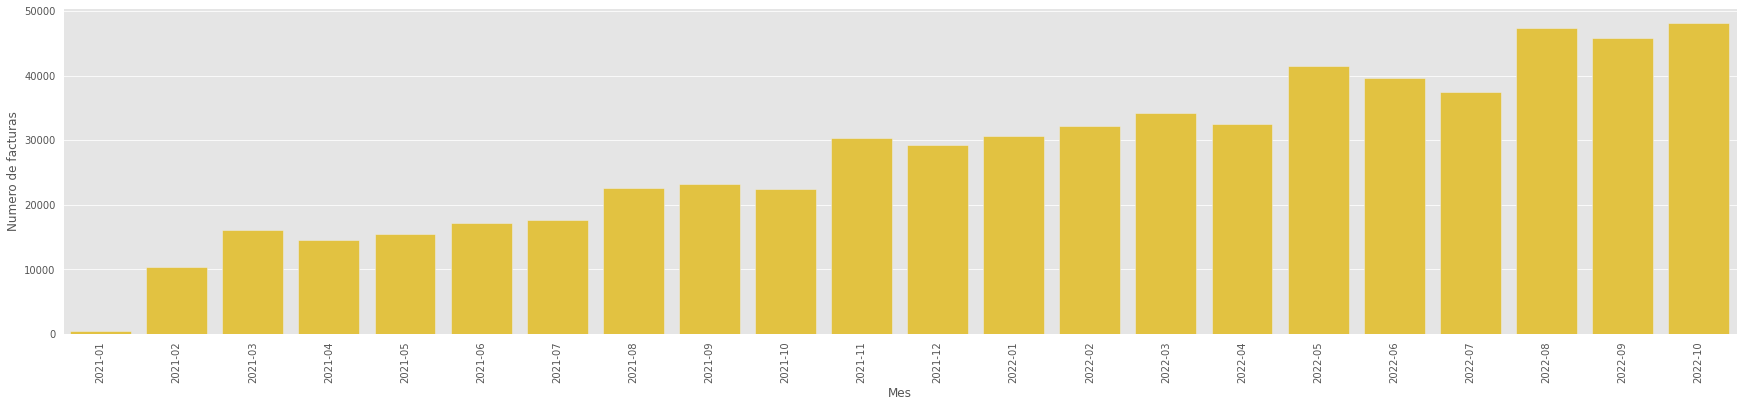

In [31]:
plt.figure(figsize=(30, 6))
sns.barplot(data=numero_pagos, x = 'index', y='Mes_Emision', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Numero de facturas')
plt.xticks(rotation=90)
plt.show()

In [32]:
Importe_por_mes = data_new.fillna(0).groupby("Mes_Emision",as_index = False)['importe_cuota'].agg(sum)
Importe_por_mes

,Mes_Emision,importe_cuota
0,2021-01,511775.9900
1,2021-02,27075228.8900
2,2021-03,41737660.4200
3,2021-04,38381626.4000
4,2021-05,41294016.0800
5,2021-06,45561541.4600
6,2021-07,48481593.7900
7,2021-08,59516261.7800
8,2021-09,62727216.1500
9,2021-10,62094438.1800


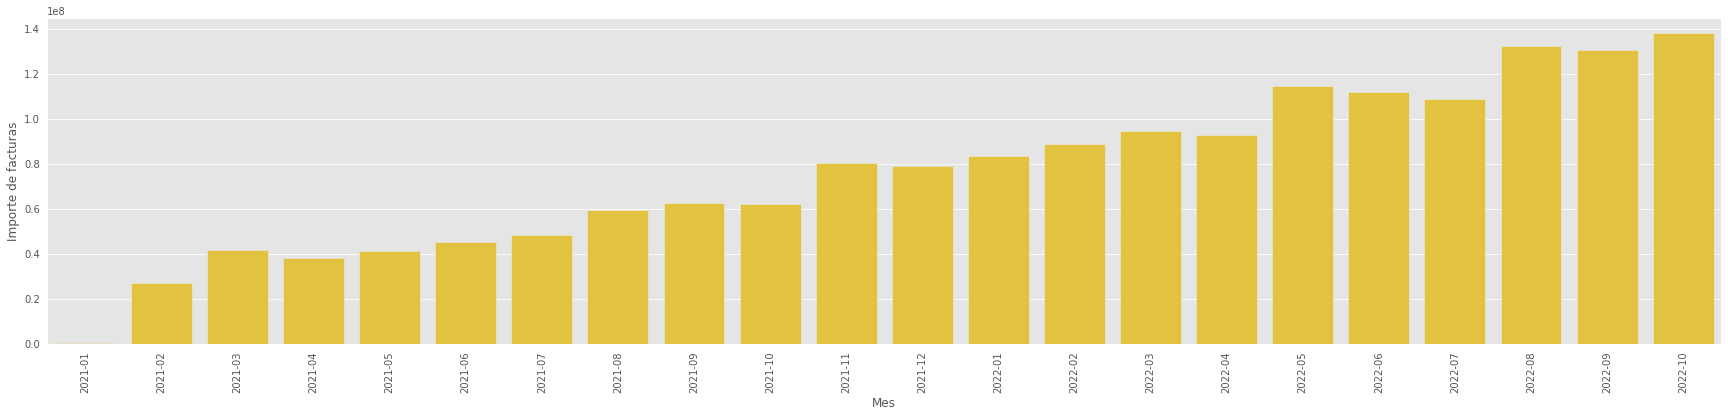

In [33]:
plt.figure(figsize=(30, 6))
sns.barplot(data=Importe_por_mes, x = 'Mes_Emision', y='importe_cuota', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Importe de facturas')
plt.xticks(rotation=90)
plt.show()

## b) Evolución de las facturas impagadas y recuperadas

In [34]:
data_new.head(1)

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente,Mes_Emision
12,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,13,2021-01-02,2021-02-02,2021-02-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-02


In [35]:
data_def=data_new[data_new['Impago']=='SI']

In [36]:
numero_impagos=pd.DataFrame(data_def['Mes_Emision'].value_counts().reset_index().sort_values('index'))
numero_impagos

,index,Mes_Emision
21,2021-01,147
20,2021-02,2615
17,2021-03,4311
19,2021-04,3981
18,2021-05,4228
15,2021-06,4649
16,2021-07,4466
14,2021-08,5421
12,2021-09,5821
13,2021-10,5704


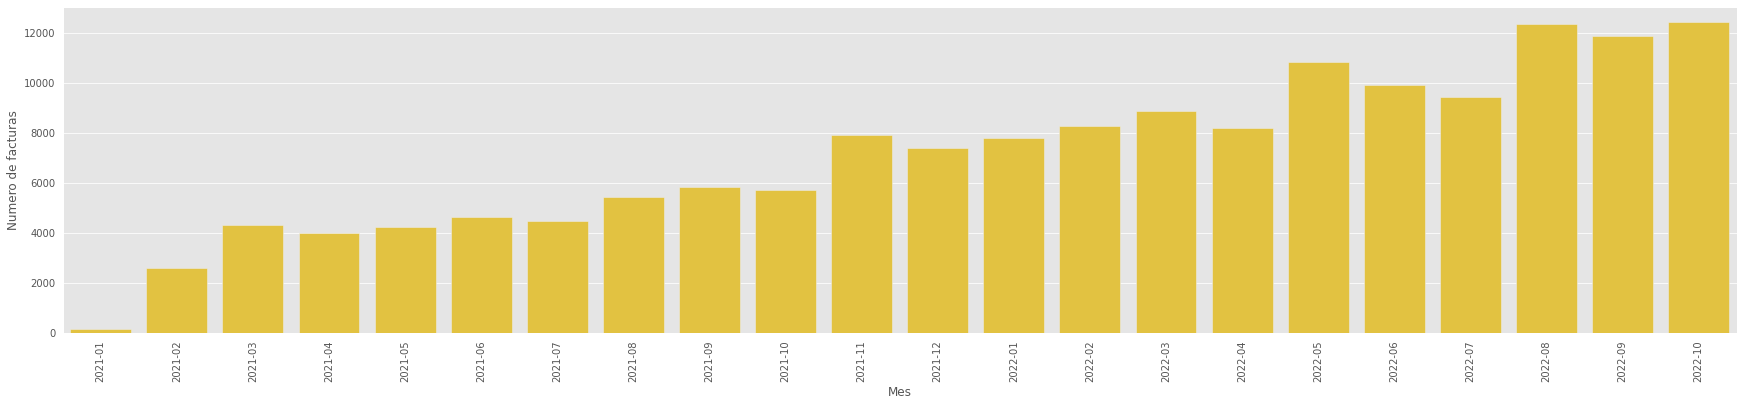

In [37]:
plt.figure(figsize=(30, 6))
sns.barplot(data=numero_impagos, x = 'index', y='Mes_Emision', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Numero de facturas')
plt.xticks(rotation=90)
plt.show()

In [38]:
data_new.head(1)

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente,Mes_Emision
12,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,13,2021-01-02,2021-02-02,2021-02-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-02


In [39]:
Importe_por_mes = data_new.fillna(0).groupby("Mes_Emision",as_index = False)['importe_impagado'].agg(sum)
Importe_por_mes

,Mes_Emision,importe_impagado
0,2021-01,139327.8000
1,2021-02,6421682.5600
2,2021-03,10592470.4600
3,2021-04,9976298.3500
4,2021-05,11002923.6000
5,2021-06,11921127.4700
6,2021-07,11940894.2300
7,2021-08,13899039.1100
8,2021-09,15038180.0100
9,2021-10,15182059.7100


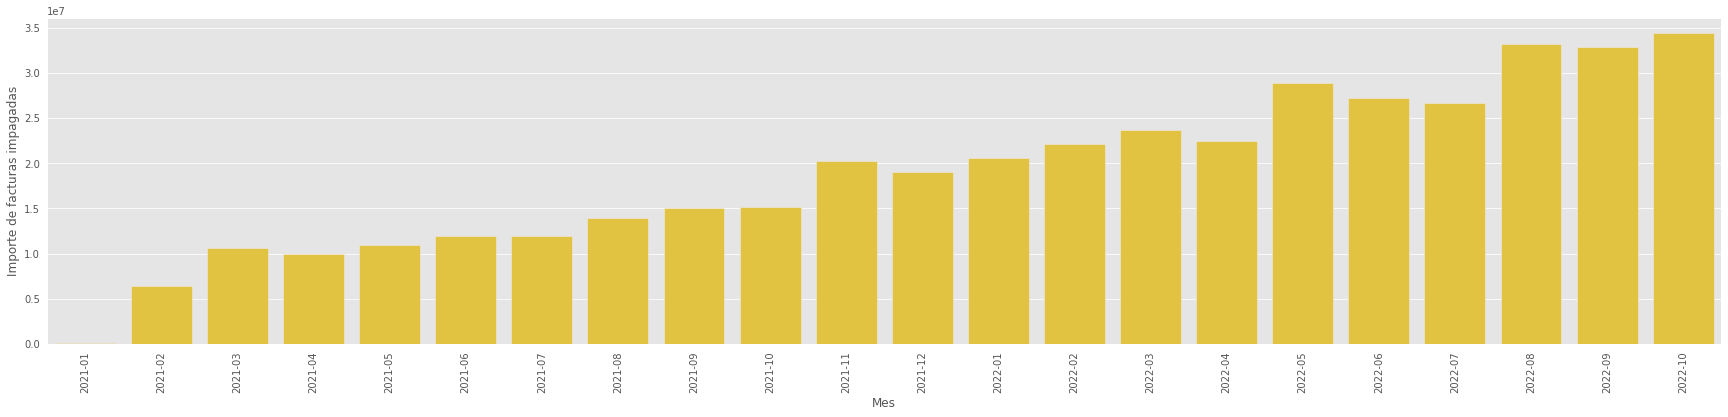

In [40]:
plt.figure(figsize=(30, 6))
sns.barplot(data=Importe_por_mes, x = 'Mes_Emision', y='importe_impagado', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Importe de facturas impagadas')
plt.xticks(rotation=90)
plt.show()

In [41]:
Importe_por_mes = data_new.fillna(0).groupby("Mes_Emision",as_index = False)['importe_recuperado'].agg(sum)
Importe_por_mes

,Mes_Emision,importe_recuperado
0,2021-01,103152.2208
1,2021-02,4209073.1508
2,2021-03,7058784.6836
3,2021-04,6618212.8552
4,2021-05,7187157.7780
5,2021-06,7632966.2680
6,2021-07,7385087.3044
7,2021-08,8372965.9416
8,2021-09,9124277.4352
9,2021-10,9234605.8332


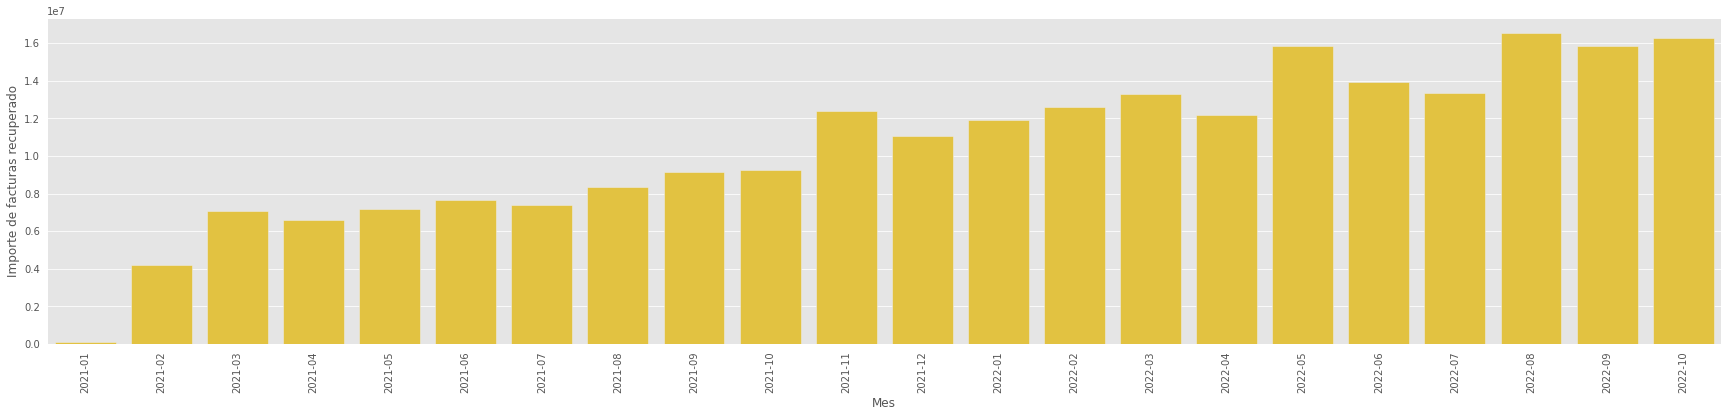

In [42]:
plt.figure(figsize=(30, 6))
sns.barplot(data=Importe_por_mes, x = 'Mes_Emision', y='importe_recuperado', color=HOCELOT_YELLOW)
#sns.pointplot(data=data, x = 'PERIOD', y='Number of recoveries', scale=.5, color=HOCELOT_RED)
plt.xlabel('Mes')
plt.ylabel('Importe de facturas recuperado')
plt.xticks(rotation=90)
plt.show()

# PUNTO 6. TIPO DE CUOTA

No aplica porque tenemos todas las facturas con su correspondiente pago

# PUNTO 7. IMPORTES NEGATIVOS

In [43]:
data_new.head(1)

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente,Mes_Emision
12,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,13,2021-01-02,2021-02-02,2021-02-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-02


In [44]:
print(data_new[data_new['importe_cuota']<0].shape)
data_new[data_new['importe_cuota']<0]

(0, 30)


,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente,Mes_Emision


In [45]:
### Podemos ignorarlos, corregirlos supondría un esfuerzo muy grande para tan poco volumen

In [46]:
print(data_new[data_new['importe_impagado']<0].shape)
data_neg = data_new[data_new['importe_impagado']<0]
data_neg[['ClienteID','importe_impagado','cuota']]

(0, 30)


,ClienteID,importe_impagado,cuota


In [47]:
print(data_new[data_new['importe_recuperado']<0].shape)
data_neg = data_new[data_new['importe_recuperado']<0]
data_neg[['ClienteID','importe_recuperado','cuota']].head()

(0, 30)


,ClienteID,importe_recuperado,cuota


# PUNTO 8. DUPLICADOS

In [48]:
data_new.shape

(609405, 30)

In [49]:
sum(data_new.duplicated())

31

Vamos a ver si un mismo clientes tiene varios contratos. Para ello usamos el ClientID y las fechas de alta y baja

In [50]:
data_new.head(1)

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente,Mes_Emision
12,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,13,2021-01-02,2021-02-02,2021-02-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-02


In [51]:
data_new.groupby('ClienteID')['Fecha_alta_contrato'].nunique().reset_index()

,ClienteID,Fecha_alta_contrato
0,13,4
1,26,3
2,31,2
3,59,4
4,76,4
...,...,...
34702,128475,1
34703,128550,1
34704,128558,1
34705,128571,1


In [52]:
data_new['ID_Contrato'] = data_new['ClienteID'].astype(str) + data_new['Fecha_alta_contrato'].astype(str) 

# PUNTO 9. FECHAS DE RECUPERACION ANTERIORES A LAS DE VENCIMIENTO

In [53]:
data_new[data_new['fecha_recuperacion']<data_new['Fecha_emision']].shape

(0, 31)

# PUNTO 10. TOTALES

In [54]:
data_new.head(1)

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente,Mes_Emision,ID_Contrato
12,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,13,2021-01-02,2021-02-02,2021-02-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-02,156182020-01-02


In [55]:
print('Importe de la factura total: {}'.format(data_new['importe_cuota'].sum()))
print('Importe impagado total: {}'.format(data_new['importe_impagado'].sum()))
print('Importe recuperado total: {}'.format(data_new['importe_recuperado'].sum()))
print('Porcentaje de importe impagado: {}'.format(100*data_new['importe_impagado'].sum()/data_new['importe_cuota'].sum()))
print('Porcentaje facturas impagadas: {}'.format(100*(data_new[data_new['Impago']=='SI'].shape[0])/(data_new.shape[0])))
print('Porcentaje de recuperacion: {}'.format(100*(data_new['importe_recuperado'].sum())/(data_new['importe_impagado'].sum())))
print('LGD: {}'.format(100*(1-(data_new['importe_recuperado'].sum())/(data_new['importe_impagado'].sum()))))

Importe de la factura total: 1683577174.5299993
Importe impagado total: 417135638.54999995
Importe recuperado total: 232069283.692
Porcentaje de importe impagado: 24.776745899186405
Porcentaje facturas impagadas: 25.69309408357332
Porcentaje de recuperacion: 55.63401019838371
LGD: 44.36598980161629


# PUNTO 11. RECOBROS SIN FECHA

In [56]:
data_new[(data_new['importe_recuperado']>0)&(data_new['fecha_recuperacion'].isnull())]

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente,Mes_Emision,ID_Contrato


# PUNTO 12. ACTUALIZACION DEL FICHERO

No aplica

# PUNTO 13. VALORES MAXIMO Y MINIMOS PARA LAS FECHAS DE ALTA Y BAJA

In [57]:
data_new.head()

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente,Mes_Emision,ID_Contrato
12,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,13,2021-01-02,2021-02-02,2021-02-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-02,156182020-01-02
13,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,14,2021-02-02,2021-03-02,2021-03-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-03,156182020-01-02
14,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,15,2021-03-02,2021-04-05,2021-04-05,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-04,156182020-01-02
15,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,16,2021-04-02,2021-05-03,2021-05-03,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-05,156182020-01-02
16,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,17,2021-05-02,2021-06-02,2021-06-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-06,156182020-01-02


In [58]:
print('La fecha de factura minimima es: {}'.format(data_new['Fecha_emision'].astype(str).min()))
print('La fecha de factura maxima es: {}'.format(data_new['Fecha_emision'].dropna().astype(str).max()))

La fecha de factura minimima es: 2021-01-01
La fecha de factura maxima es: 2022-10-24


In [59]:
print('La fecha de baja minimima es: {}'.format(data_new['Fecha_baja'].astype(str).min()))
print('La fecha de baja maxima es: {}'.format(data_new['Fecha_baja'].dropna().astype(str).max()))

La fecha de baja minimima es: 2021-01-11
La fecha de baja maxima es: 2023-03-31


In [60]:
print('La fecha de alta minimima es: {}'.format(data_new['Fecha_alta_contrato'].astype(str).min()))
print('La fecha de alta maxima es: {}'.format(data_new['Fecha_alta_contrato'].astype(str).max()))

La fecha de alta minimima es: 2020-01-02
La fecha de alta maxima es: 2022-10-24


# PUNTO 14. DIAS DE RETRASO

In [61]:
def cambiar_fec_recu(Fecha):
    try:
        return datetime.strptime(Fecha, '%Y-%m-%d')
    except:
        if Fecha==Fecha:
            print(Fecha)
        return datetime.strptime('2023-02-28', '%Y-%m-%d')

In [62]:
data_new['Fecha recuperación_auxiliar']=data_new['fecha_recuperacion'].apply(cambiar_fec_recu)

In [63]:
data_new['Fecha recuperación_auxiliar'] = pd.to_datetime(data_new['Fecha recuperación_auxiliar'])

In [64]:
data_new['Fecha_vencimiento'] = pd.to_datetime(data_new['Fecha_vencimiento'])

In [65]:
data_new['dias_en_default']=np.where(data_new['Impago']=='SI' , 
                                     data_new['Fecha recuperación_auxiliar'] - data_new['Fecha_vencimiento'] , 
                                     data_new['Fecha recuperación_auxiliar'] - data_new['Fecha recuperación_auxiliar'])

In [66]:
data_new.shape

(609405, 33)

In [67]:
data_new[data_new['Impago']=='SI'].head()

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente,Mes_Emision,ID_Contrato,Fecha recuperación_auxiliar,dias_en_default
19,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,20,2021-08-02,2021-09-02,NaN,1480.0000,SI,1480.0000,0.0000,NaN,672,E1,2021-09,156182020-01-02,2023-02-28,544 days
20,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,21,2021-09-02,2021-10-04,NaN,1480.0000,SI,1480.0000,0.0000,NaN,672,E1,2021-10,156182020-01-02,2023-02-28,512 days
21,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,22,2021-10-02,2021-11-03,NaN,1480.0000,SI,1480.0000,0.0000,NaN,672,E1,2021-11,156182020-01-02,2023-02-28,482 days
22,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,23,2021-11-02,2021-12-02,NaN,1480.0000,SI,1480.0000,0.0000,NaN,672,E1,2021-12,156182020-01-02,2023-02-28,453 days
23,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,24,2021-12-02,2022-01-03,NaN,1480.0000,SI,1480.0000,0.0000,NaN,672,E1,2022-01,156182020-01-02,2023-02-28,421 days


In [68]:
data_new['dias_en_default'] = pd.to_numeric(data_new['dias_en_default'].dropna().astype(str).str.split(' ').apply(lambda x: x[0]))

In [69]:
data_new['Default_1_dias'] = np.where(data_new['dias_en_default']>0, 1, 0)
print('Numero de facturas con mas de 90 dias de atraso: {}'.format(data_new['Default_1_dias'].sum()))
print('Porcentaje de facturas con mas de 90 dias de atraso: {}'.format(100*(data_new['Default_1_dias'].sum()/data_new['Default_1_dias'].shape[0])))
print('Porcentaje de dinero impagado mas de 90 dias de atraso: {}'.format(100*(data_new[data_new['Default_1_dias']>0]['importe_impagado'].sum()/data_new['importe_cuota'].sum())))

Numero de facturas con mas de 90 dias de atraso: 156575
Porcentaje de facturas con mas de 90 dias de atraso: 25.69309408357332
Porcentaje de dinero impagado mas de 90 dias de atraso: 24.776745899186405


In [70]:
data_new['Default_90_dias'] = np.where(data_new['dias_en_default']>90, 1, 0)
print('Numero de facturas con mas de 90 dias de atraso: {}'.format(data_new['Default_90_dias'].sum()))
print('Porcentaje de facturas con mas de 90 dias de atraso: {}'.format(100*(data_new['Default_90_dias'].sum()/data_new['Default_90_dias'].shape[0])))
print('Porcentaje de dinero impagado mas de 90 dias de atraso: {}'.format(100*(data_new[data_new['Default_90_dias']>0]['importe_impagado'].sum()/data_new['importe_cuota'].sum())))

Numero de facturas con mas de 90 dias de atraso: 66502
Porcentaje de facturas con mas de 90 dias de atraso: 10.912611481691158
Porcentaje de dinero impagado mas de 90 dias de atraso: 11.230153260588235


In [71]:
data_new['Default_120_dias'] = np.where(data_new['dias_en_default']>120, 1, 0)
print('Numero de facturas con mas de 120 dias de atraso: {}'.format(data_new['Default_120_dias'].sum()))
print('Porcentaje de facturas con mas de 120 dias de atraso: {}'.format(100*(data_new['Default_120_dias'].sum()/data_new['Default_120_dias'].shape[0])))
print('Porcentaje de dinero impagado mas de 120 dias de atraso: {}'.format(100*(data_new[data_new['Default_120_dias']>0]['importe_impagado'].sum()/data_new['importe_cuota'].sum())))

Numero de facturas con mas de 120 dias de atraso: 64597
Porcentaje de facturas con mas de 120 dias de atraso: 10.600011486613994
Porcentaje de dinero impagado mas de 120 dias de atraso: 10.917016696386966


#### Si una factura es mora, el contrato es moroso. Creamos esta variable

In [72]:
data_def_cont=data_new.groupby(['ID_Contrato'],as_index = False)[['Default_120_dias','Default_90_dias', 'Default_1_dias']].agg(Default_120_dias_cont = ('Default_120_dias', max), Default_90_dias_cont = ('Default_90_dias', max), Default_1_dias_cont = ('Default_1_dias', max))
data_def_cont

,ID_Contrato,Default_120_dias_cont,Default_90_dias_cont,Default_1_dias_cont
0,1000002022-06-15,0,0,0
1,1000052022-06-15,0,0,0
2,1000052022-08-11,0,0,0
3,1000052022-10-20,0,0,0
4,1000072022-06-15,0,0,0
...,...,...,...,...
56373,999932022-06-15,0,0,1
56374,999962022-06-16,0,0,0
56375,999962022-09-15,0,0,1
56376,999972022-06-15,0,0,0


In [73]:
print('Numero de contratos con alguna de sus facturas con mas de 1 dias de atraso: {}'.format(data_def_cont['Default_1_dias_cont'].sum()))
print('Porcentaje de contratos con alguna de sus facturas con mas de 1 dias de atraso: {}'.format(100*data_def_cont['Default_1_dias_cont'].sum()/data_def_cont.shape[0]))
print('Numero de contratos con alguna de sus facturas con mas de 90 dias de atraso: {}'.format(data_def_cont['Default_90_dias_cont'].sum()))
print('Porcentaje de contratos con alguna de sus facturas con mas de 90 dias de atraso: {}'.format(100*data_def_cont['Default_90_dias_cont'].sum()/data_def_cont.shape[0]))
print('Numero de contratos con alguna de sus facturas con mas de 120 dias de atraso: {}'.format(data_def_cont['Default_120_dias_cont'].sum()))
print('Porcentaje de contratos con alguna de sus facturas con mas de 120 dias de atraso: {}'.format(100*data_def_cont['Default_120_dias_cont'].sum()/data_def_cont.shape[0]))

Numero de contratos con alguna de sus facturas con mas de 1 dias de atraso: 30058
Porcentaje de contratos con alguna de sus facturas con mas de 1 dias de atraso: 53.315122920288054
Numero de contratos con alguna de sus facturas con mas de 90 dias de atraso: 7947
Porcentaje de contratos con alguna de sus facturas con mas de 90 dias de atraso: 14.095923941963177
Numero de contratos con alguna de sus facturas con mas de 120 dias de atraso: 7671
Porcentaje de contratos con alguna de sus facturas con mas de 120 dias de atraso: 13.60637127957714


In [74]:
data_new = data_new.merge(data_def_cont, how='left', on='ID_Contrato')

#### Si una contrato es mora, el cliente es moroso. Creamos esta variable

In [75]:
data_def_pers=data_new.groupby(['ClienteID'],as_index = False)[['Default_120_dias_cont','Default_90_dias_cont']].agg(Default_120_dias_pers = ('Default_120_dias_cont', max), Default_90_dias_pers = ('Default_90_dias_cont', max))
data_def_pers

,ClienteID,Default_120_dias_pers,Default_90_dias_pers
0,13,0,0
1,26,0,0
2,31,0,0
3,59,0,0
4,76,1,1
...,...,...,...
34702,128475,0,0
34703,128550,0,0
34704,128558,0,0
34705,128571,0,0


In [76]:
print('Numero de clientes con alguna de sus facturas con mas de 90 dias de atraso: {}'.format(data_def_pers['Default_90_dias_pers'].sum()))
print('Porcentaje de clientes con alguna de sus facturas con mas de 90 dias de atraso: {}'.format(100*data_def_pers['Default_90_dias_pers'].sum()/data_def_pers.shape[0]))
print('Numero de clientes con alguna de sus facturas con mas de 120 dias de atraso: {}'.format(data_def_pers['Default_120_dias_pers'].sum()))
print('Porcentaje de clientes con alguna de sus facturas con mas de 120 dias de atraso: {}'.format(100*data_def_pers['Default_120_dias_pers'].sum()/data_def_pers.shape[0]))

Numero de clientes con alguna de sus facturas con mas de 90 dias de atraso: 6793
Porcentaje de clientes con alguna de sus facturas con mas de 90 dias de atraso: 19.572420549168754
Numero de clientes con alguna de sus facturas con mas de 120 dias de atraso: 6565
Porcentaje de clientes con alguna de sus facturas con mas de 120 dias de atraso: 18.91549255193477


In [77]:
data_new = data_new.merge(data_def_pers, how='left', on='ClienteID')

In [78]:
print(data_new.shape)
data_new.head()

(609405, 41)


,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente,Mes_Emision,ID_Contrato,Fecha recuperación_auxiliar,dias_en_default,Default_1_dias,Default_90_dias,Default_120_dias,Default_120_dias_cont,Default_90_dias_cont,Default_1_dias_cont,Default_120_dias_pers,Default_90_dias_pers
0,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,13,2021-01-02,2021-02-02,2021-02-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-02,156182020-01-02,2023-02-28,0,0,0,0,1,1,1,1,1
1,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,14,2021-02-02,2021-03-02,2021-03-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-03,156182020-01-02,2023-02-28,0,0,0,0,1,1,1,1,1
2,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,15,2021-03-02,2021-04-05,2021-04-05,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-04,156182020-01-02,2023-02-28,0,0,0,0,1,1,1,1,1
3,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,16,2021-04-02,2021-05-03,2021-05-03,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-05,156182020-01-02,2023-02-28,0,0,0,0,1,1,1,1,1
4,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,17,2021-05-02,2021-06-02,2021-06-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-06,156182020-01-02,2023-02-28,0,0,0,0,1,1,1,1,1


#### Calculo LGD

In [79]:
data_new[data_new['Default_120_dias']==1]['importe_recuperado'].sum()

2210607.3508

In [80]:
print('LGD 90 (facturas): {}'.format(100*(1-(data_new[data_new['Default_90_dias']==1]['importe_recuperado'].sum())/(data_new[data_new['Default_90_dias']==1]['importe_impagado'].sum()))))
print('LGD 120 (facturas): {}'.format(100*(1-(data_new[data_new['Default_120_dias']==1]['importe_recuperado'].sum())/(data_new[data_new['Default_120_dias']==1]['importe_impagado'].sum()))))
print('LGD 90 (contratos): {}'.format(100*(1-(data_new[data_new['Default_90_dias_cont']==1]['importe_recuperado'].sum())/(data_new[data_new['Default_90_dias_cont']==1]['importe_impagado'].sum()))))
print('LGD 120 (contratos): {}'.format(100*(1-(data_new[data_new['Default_120_dias_cont']==1]['importe_recuperado'].sum())/(data_new[data_new['Default_120_dias_cont']==1]['importe_impagado'].sum()))))

LGD 90 (facturas): 97.21011706181712
LGD 120 (facturas): 98.79725210293242
LGD 90 (contratos): 76.77222409887557
LGD 120 (contratos): 78.41425066322422


# PUNTO 15. EMPRESAS

No lo podemos saber

# PUNTO 16. TENURE

In [81]:
def cambiar_fec_feb(Fecha):
    try:
        return datetime.strptime(Fecha, '%Y-%m-%d')
    except:
        if Fecha==Fecha:
            print(Fecha)
        return datetime.strptime('2023-02-28', '%Y-%m-%d')

def cambiar_fec_oct(Fecha):
    try:
        return datetime.strptime(Fecha, '%Y-%m-%d')
    except:
        if Fecha==Fecha:
            print(Fecha)
        return datetime.strptime('2022-10-31', '%Y-%m-%d')
    
def cambiar_fec_abr(Fecha):
    try:
        return datetime.strptime(Fecha, '%Y-%m-%d')
    except:
        if Fecha==Fecha:
            print(Fecha)
        return datetime.strptime('2022-04-30', '%Y-%m-%d')

In [82]:
data_new['Fecha_baja_auxiliar_feb'] = data_new['Fecha_baja'].apply(cambiar_fec_feb)
data_new['Fecha_baja_auxiliar_oct'] = data_new['Fecha_baja'].apply(cambiar_fec_oct)
data_new['Fecha_baja_auxiliar_abr'] = data_new['Fecha_baja'].apply(cambiar_fec_abr)

In [83]:
data_new['Fecha_baja_auxiliar_feb'] = pd.to_datetime(data_new['Fecha_baja_auxiliar_feb'])
data_new['Fecha_baja_auxiliar_oct'] = pd.to_datetime(data_new['Fecha_baja_auxiliar_oct'])
data_new['Fecha_baja_auxiliar_abr'] = pd.to_datetime(data_new['Fecha_baja_auxiliar_abr'])
data_new['Fecha_alta_contrato'] = pd.to_datetime(data_new['Fecha_alta_contrato'])

In [84]:
data_new.head(1)

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente,Mes_Emision,ID_Contrato,Fecha recuperación_auxiliar,dias_en_default,Default_1_dias,Default_90_dias,Default_120_dias,Default_120_dias_cont,Default_90_dias_cont,Default_1_dias_cont,Default_120_dias_pers,Default_90_dias_pers,Fecha_baja_auxiliar_feb,Fecha_baja_auxiliar_oct,Fecha_baja_auxiliar_abr
0,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,13,2021-01-02,2021-02-02,2021-02-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-02,156182020-01-02,2023-02-28,0,0,0,0,1,1,1,1,1,2022-02-02,2022-02-02,2022-02-02


In [85]:
data_new['tenure_febrero_2023'] = (data_new['Fecha_baja_auxiliar_feb'] - data_new['Fecha_alta_contrato']).dt.days
data_new['tenure_octubre_2022'] = (data_new['Fecha_baja_auxiliar_oct'] - data_new['Fecha_alta_contrato']).dt.days
data_new['tenure_abril_2022'] = (data_new['Fecha_baja_auxiliar_abr'] - data_new['Fecha_alta_contrato']).dt.days

In [86]:
data_new.sample(5)

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente,Mes_Emision,ID_Contrato,Fecha recuperación_auxiliar,dias_en_default,Default_1_dias,Default_90_dias,Default_120_dias,Default_120_dias_cont,Default_90_dias_cont,Default_1_dias_cont,Default_120_dias_pers,Default_90_dias_pers,Fecha_baja_auxiliar_feb,Fecha_baja_auxiliar_oct,Fecha_baja_auxiliar_abr,tenure_febrero_2023,tenure_octubre_2022,tenure_abril_2022
246199,1997-01-07,Residencial el Refugio,Querétaro,Querétaro de Arteaga,76146,Soltero,V,50705,NVO,10600.0000,12,1183.0000,48.9000,2021-04-29,2022-04-29,M,P,SI,9,2021-12-29,2022-01-31,2021-07-12,1183.0000,NO,0.0000,0.0000,NaN,668,D3,2022-01,507052021-04-29,2023-02-28,0,0,0,0,0,0,0,0,0,2022-04-29,2022-04-29,2022-04-29,365,365,365
447775,2001-10-07,VAMOS TAMAULIPAS,Victoria,Tamaulipas,87016,Soltero,H,67412,NVO,10000.0000,12,1157.0000,55.8000,2021-11-16,2022-11-16,M,T,NO,4,2022-02-16,2022-03-16,2022-03-16,1157.0000,NO,0.0000,0.0000,NaN,661,D5,2022-03,674122021-11-16,2023-02-28,0,0,0,0,0,0,1,0,0,2022-11-16,2022-11-16,2022-11-16,365,365,365
9281,1971-05-03,Jardines de San José,Juárez,Chihuahua,32390,Soltero,V,32301,REN,39264.0000,29,2355.0000,32.0900,2020-01-27,2022-07-27,M,T,SI,24,2022-01-27,2022-02-28,2021-02-15,2355.0000,NO,0.0000,0.0000,NaN,633,B2,2022-02,323012020-01-27,2023-02-28,0,0,0,0,1,1,1,1,1,2022-07-27,2022-07-27,2022-07-27,912,912,912
500179,1982-03-02,Carmen Serdán,Coyoacan,Ciudad de México,04910,Soltero,H,74949,NVO,20000.0000,12,2341.0000,57.9500,2022-01-27,2023-01-27,M,P,NO,2,2022-02-27,2022-03-28,2022-03-28,2341.0000,NO,0.0000,0.0000,NaN,668,E1,2022-03,749492022-01-27,2023-02-28,0,0,0,0,0,0,1,0,0,2023-01-27,2023-01-27,2023-01-27,365,365,365
100022,1990-01-30,CENTRO,Ascensión,Chihuahua,31820,Soltero,H,28222,REN,26203.0000,96,477.5700,57.2000,2020-09-23,2022-07-27,S,P,NO,30,2021-04-14,2021-04-21,NaN,477.5700,SI,462.5200,462.5300,2021-04-22,685,E1,2021-04,282222020-09-23,2021-04-22,1,1,0,0,1,1,1,1,1,2022-07-27,2022-07-27,2022-07-27,672,672,672


### Distribucion de Tenure

In [87]:
print(data_new['tenure_febrero_2023'].quantile(0.05))
print(data_new['tenure_febrero_2023'].quantile(0.1))
print(data_new['tenure_febrero_2023'].quantile(0.9))
print(data_new['tenure_febrero_2023'].quantile(0.95))
data_new['tenure_febrero_2023'].describe()

212.0
267.0
866.0
987.0


count   609405.0000
mean       546.7466
std        229.8173
min         28.0000
25%        365.0000
50%        540.0000
75%        727.0000
max       1155.0000
Name: tenure_febrero_2023, dtype: float64

In [88]:
print(data_new['tenure_febrero_2023'].quantile(0.05))
print(data_new['tenure_febrero_2023'].quantile(0.1))
print(data_new['tenure_febrero_2023'].quantile(0.9))
print(data_new['tenure_febrero_2023'].quantile(0.95))
data_new['tenure_febrero_2023'].describe()

212.0
267.0
866.0
987.0


count   609405.0000
mean       546.7466
std        229.8173
min         28.0000
25%        365.0000
50%        540.0000
75%        727.0000
max       1155.0000
Name: tenure_febrero_2023, dtype: float64

In [89]:
print(data_new['tenure_febrero_2023'].quantile(0.05))
print(data_new['tenure_febrero_2023'].quantile(0.1))
print(data_new['tenure_febrero_2023'].quantile(0.9))
print(data_new['tenure_febrero_2023'].quantile(0.95))
data_new['tenure_febrero_2023'].describe()

212.0
267.0
866.0
987.0


count   609405.0000
mean       546.7466
std        229.8173
min         28.0000
25%        365.0000
50%        540.0000
75%        727.0000
max       1155.0000
Name: tenure_febrero_2023, dtype: float64

# LIMPIO DATASET DE VARIBLES AUXILIARES

In [90]:
data_new.head(1)

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,cuota,TIN,Fecha_alta_contrato,Fecha_baja,Frecuencia_pago,TipoProducto2,pago_adelantado,#Cuota,Fecha_emision,Fecha_vencimiento,fecha_pago,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,Score_usado_actualmente,Mes_Emision,ID_Contrato,Fecha recuperación_auxiliar,dias_en_default,Default_1_dias,Default_90_dias,Default_120_dias,Default_120_dias_cont,Default_90_dias_cont,Default_1_dias_cont,Default_120_dias_pers,Default_90_dias_pers,Fecha_baja_auxiliar_feb,Fecha_baja_auxiliar_oct,Fecha_baja_auxiliar_abr,tenure_febrero_2023,tenure_octubre_2022,tenure_abril_2022
0,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,06300,Soltero,H,15618,REN,20301.0000,25,1480.0000,53.7600,2020-01-02,2022-02-02,M,T,NO,13,2021-01-02,2021-02-02,2021-02-02,1480.0000,NO,0.0000,0.0000,NaN,672,E1,2021-02,156182020-01-02,2023-02-28,0,0,0,0,1,1,1,1,1,2022-02-02,2022-02-02,2022-02-02,762,762,762


In [91]:
data_new.drop(columns=['TIN','TipoProducto2','pago_adelantado','#Cuota','Frecuencia_pago',
                       'fecha_pago','Score_usado_actualmente','Mes_Emision',
                       'Fecha recuperación_auxiliar','Fecha_baja_auxiliar_feb','Fecha_baja_auxiliar_oct','Fecha_baja_auxiliar_abr',
                      'Fecha_alta_contrato','cuota'], inplace=True)

# GUARDO DATASET POST QA0

In [92]:
data_new.to_csv('gs://hocelot_mx_analytics/progress/00020-kubofinanciero/df_post_QA0.csv',sep=';', index=False)

In [93]:
data_new=pd.read_csv('gs://hocelot_mx_analytics/progress/00020-kubofinanciero/df_post_QA0.csv', sep=';',index_col=False)

In [94]:
print(data_new.shape)
data_new.head()

(609405, 33)


,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,Fecha_baja,Fecha_emision,Fecha_vencimiento,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,ID_Contrato,dias_en_default,Default_1_dias,Default_90_dias,Default_120_dias,Default_120_dias_cont,Default_90_dias_cont,Default_1_dias_cont,Default_120_dias_pers,Default_90_dias_pers,tenure_febrero_2023,tenure_octubre_2022,tenure_abril_2022
0,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,Soltero,H,15618,REN,20301.0000,25,2022-02-02,2021-01-02,2021-02-02,1480.0000,NO,0.0000,0.0000,NaN,672,156182020-01-02,0,0,0,0,1,1,1,1,1,762,762,762
1,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,Soltero,H,15618,REN,20301.0000,25,2022-02-02,2021-02-02,2021-03-02,1480.0000,NO,0.0000,0.0000,NaN,672,156182020-01-02,0,0,0,0,1,1,1,1,1,762,762,762
2,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,Soltero,H,15618,REN,20301.0000,25,2022-02-02,2021-03-02,2021-04-05,1480.0000,NO,0.0000,0.0000,NaN,672,156182020-01-02,0,0,0,0,1,1,1,1,1,762,762,762
3,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,Soltero,H,15618,REN,20301.0000,25,2022-02-02,2021-04-02,2021-05-03,1480.0000,NO,0.0000,0.0000,NaN,672,156182020-01-02,0,0,0,0,1,1,1,1,1,762,762,762
4,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,Soltero,H,15618,REN,20301.0000,25,2022-02-02,2021-05-02,2021-06-02,1480.0000,NO,0.0000,0.0000,NaN,672,156182020-01-02,0,0,0,0,1,1,1,1,1,762,762,762


In [95]:
data_new['ClienteID'].nunique()

34707

# Me quedo con informacion por cliente para hacer el modelo

In [102]:
data_new['product_NVO'] = np.where(data_new['TipoProducto']=='NVO',1,0)
data_new['product_REN'] = np.where(data_new['TipoProducto']=='REN',1,0)

In [103]:
data_clientes = data_new[['ClienteID','Fecha_de_Nacimiento','Colonia','Municipio','Entidad_federativa','Codigo Postal','Estado civil','Genero',
                          'product_NVO','product_REN','Valor_producto','No_cuotas','Bureau_de_credito',
                        'Default_90_dias_pers']].drop_duplicates()

In [101]:
data_new['TipoProducto'].value_counts()

NVO    306705
REN    302700
Name: TipoProducto, dtype: int64

In [100]:
data_clientes.shape 

(56838, 13)

In [111]:
data_aux = data_clientes.groupby('ClienteID').agg({'product_NVO':'max',
                                        'product_REN':'max',
                                        'Valor_producto':'mean', 
                                        'No_cuotas':'mean',
                                        'Bureau_de_credito':'mean'
                                       })
print(data_aux.shape)
data_aux.head()

(34707, 5)


,product_NVO,product_REN,Valor_producto,No_cuotas,Bureau_de_credito
ClienteID,,,,,
13,0,1,46250.0000,36.0000,652.2500
26,0,1,25628.6667,8.0000,677.6667
31,0,1,20394.0000,18.0000,663.0000
59,0,1,106500.0000,20.0000,672.5000
76,0,1,74399.7500,39.5000,641.7500


In [114]:
data_clientes.drop(columns=['product_NVO','product_REN','Valor_producto','No_cuotas','Bureau_de_credito'],inplace=True)

In [117]:
data_clientes_1 = data_clientes.merge(data_aux, how='inner',on='ClienteID').drop_duplicates()
print(data_clientes_1.shape)
data_clientes_1.head()

(34708, 14)


,ClienteID,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,Default_90_dias_pers,product_NVO,product_REN,Valor_producto,No_cuotas,Bureau_de_credito
0,15618,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,Soltero,H,1,0,1,20972.5000,30.5000,661.5000
2,18337,1969-07-15,CERRO AZUL,Cerro Azul,Veracruz Llave,92514,Soltero,H,1,0,1,50000.0000,39.0000,721.0000
3,19274,1987-02-20,Zacatenco,Tlahuac,Ciudad de México,13440,Soltero,H,1,0,1,25000.0000,18.0000,680.0000
4,15526,1983-08-18,Real del Monte,Alvaro Obregon,Ciudad de México,1130,Soltero,V,1,0,1,99489.0000,40.0000,623.0000
5,31257,1975-01-15,Corredor Industrial Toluca Lerma,Lerma,Estado de México,52004,Soltero,V,1,1,0,66700.0000,38.0000,679.0000


In [118]:
data_clientes_1.to_csv('gs://hocelot_mx_analytics/progress/00020-kubofinanciero/df_to_model.csv',sep=';',index=False)

# PREPARO DATASET PARA ENRIQUECER

In [119]:
tenure_febrero_2023 = data_new.groupby('ClienteID').agg({'tenure_febrero_2023':'max'})
data_new = data_new.merge(tenure_febrero_2023, how= 'inner', on='ClienteID')
tenure_octubre_2022 = data_new.groupby('ClienteID').agg({'tenure_octubre_2022':'max'})
data_new = data_new.merge(tenure_octubre_2022, how= 'inner', on='ClienteID')
tenure_abril_2022 = data_new.groupby('ClienteID').agg({'tenure_abril_2022':'max'})
data_new = data_new.merge(tenure_abril_2022, how= 'inner', on='ClienteID')

In [120]:
data_new.rename(columns={'tenure_febrero_2023_y':'tenure_febrero_2023_cliente', 'tenure_febrero_2023_x':'tenure_febrero_2023_contrato',
                 'tenure_octubre_2022_y':'tenure_octubre_2022_cliente', 'tenure_octubre_2022_x':'tenure_octubre_2022_contrato',
                 'tenure_abril_2022_y':'tenure_abril_2022_cliente', 'tenure_abril_2022_x':'tenure_abril_2022_contrato'},inplace=True)

In [121]:
data_new.head()

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,ClienteID,TipoProducto,Valor_producto,No_cuotas,Fecha_baja,Fecha_emision,Fecha_vencimiento,importe_cuota,Impago,importe_impagado,importe_recuperado,fecha_recuperacion,Bureau_de_credito,ID_Contrato,dias_en_default,Default_1_dias,Default_90_dias,Default_120_dias,Default_120_dias_cont,Default_90_dias_cont,Default_1_dias_cont,Default_120_dias_pers,Default_90_dias_pers,tenure_febrero_2023_contrato,tenure_octubre_2022_contrato,tenure_abril_2022_contrato,product_NVO,product_REN,tenure_febrero_2023_cliente,tenure_octubre_2022_cliente,tenure_abril_2022_cliente
0,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,Soltero,H,15618,REN,20301.0000,25,2022-02-02,2021-01-02,2021-02-02,1480.0000,NO,0.0000,0.0000,NaN,672,156182020-01-02,0,0,0,0,1,1,1,1,1,762,762,762,0,1,981,861,762
1,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,Soltero,H,15618,REN,20301.0000,25,2022-02-02,2021-02-02,2021-03-02,1480.0000,NO,0.0000,0.0000,NaN,672,156182020-01-02,0,0,0,0,1,1,1,1,1,762,762,762,0,1,981,861,762
2,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,Soltero,H,15618,REN,20301.0000,25,2022-02-02,2021-03-02,2021-04-05,1480.0000,NO,0.0000,0.0000,NaN,672,156182020-01-02,0,0,0,0,1,1,1,1,1,762,762,762,0,1,981,861,762
3,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,Soltero,H,15618,REN,20301.0000,25,2022-02-02,2021-04-02,2021-05-03,1480.0000,NO,0.0000,0.0000,NaN,672,156182020-01-02,0,0,0,0,1,1,1,1,1,762,762,762,0,1,981,861,762
4,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,Soltero,H,15618,REN,20301.0000,25,2022-02-02,2021-05-02,2021-06-02,1480.0000,NO,0.0000,0.0000,NaN,672,156182020-01-02,0,0,0,0,1,1,1,1,1,762,762,762,0,1,981,861,762


In [126]:
data_clientes = data_new[['ClienteID','Fecha_de_Nacimiento','Colonia','Municipio','Entidad_federativa','Codigo Postal','Estado civil','Genero',
                        'Default_90_dias_pers','tenure_octubre_2022_cliente','tenure_abril_2022_cliente','tenure_febrero_2023_cliente']]
data_clientes.drop_duplicates(inplace=True)
print(data_clientes.shape)
data_clientes.head()

(34708, 12)


,ClienteID,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,Default_90_dias_pers,tenure_octubre_2022_cliente,tenure_abril_2022_cliente,tenure_febrero_2023_cliente
0,15618,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,Soltero,H,1,861,762,981
34,18337,1969-07-15,CERRO AZUL,Cerro Azul,Veracruz Llave,92514,Soltero,H,1,1033,849,1153
55,19274,1987-02-20,Zacatenco,Tlahuac,Ciudad de México,13440,Soltero,H,1,547,547,547
61,15526,1983-08-18,Real del Monte,Alvaro Obregon,Ciudad de México,1130,Soltero,V,1,1033,849,1153
82,31257,1975-01-15,Corredor Industrial Toluca Lerma,Lerma,Estado de México,52004,Soltero,V,1,1033,849,1153


In [136]:
data_clientes = data_clientes[(data_clientes['Colonia']!='BARR La Candelaria')]

In [137]:
print(data_clientes.shape)
data_clientes.head()

(34707, 12)


,ClienteID,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Estado civil,Genero,Default_90_dias_pers,tenure_octubre_2022_cliente,tenure_abril_2022_cliente,tenure_febrero_2023_cliente
0,15618,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,Soltero,H,1,861,762,981
34,18337,1969-07-15,CERRO AZUL,Cerro Azul,Veracruz Llave,92514,Soltero,H,1,1033,849,1153
55,19274,1987-02-20,Zacatenco,Tlahuac,Ciudad de México,13440,Soltero,H,1,547,547,547
61,15526,1983-08-18,Real del Monte,Alvaro Obregon,Ciudad de México,1130,Soltero,V,1,1033,849,1153
82,31257,1975-01-15,Corredor Industrial Toluca Lerma,Lerma,Estado de México,52004,Soltero,V,1,1033,849,1153


In [138]:
data_clientes['pk'] = range(1, data_clientes.shape[0]+1)

In [139]:
df_to_enrich_con_ID = data_clientes[['ClienteID','Fecha_de_Nacimiento','Colonia','Municipio','Entidad_federativa','Codigo Postal','Genero','pk']]

In [62]:
df_to_enrich = data_clientes[['Fecha_de_Nacimiento','Colonia','Municipio','Entidad_federativa','Codigo Postal','Genero','pk']]

In [66]:
df_to_enrich.head()

,Fecha_de_Nacimiento,Colonia,Municipio,Entidad_federativa,Codigo Postal,Genero,pk
0,1993-08-18,Guerrero,Cuauhtemoc,Ciudad de México,6300,H,1
34,1969-07-15,CERRO AZUL,Cerro Azul,Veracruz Llave,92514,H,2
55,1987-02-20,Zacatenco,Tlahuac,Ciudad de México,13440,H,3
61,1983-08-18,Real del Monte,Alvaro Obregon,Ciudad de México,1130,V,4
82,1975-01-15,Corredor Industrial Toluca Lerma,Lerma,Estado de México,52004,V,5


In [140]:
df_to_enrich_con_ID.to_csv('gs://hocelot_mx_analytics/progress/00020-kubofinanciero/df_to_enrich_Kubo_ID.csv', sep=';', index=False)

In [67]:
df_to_enrich.to_csv('gs://hocelot_mx_analytics/progress/00020-kubofinanciero/df_to_enrich_Kubo.csv', sep=';', index=False)